In [ ]:
import gdown
!gdown "1aqRMl4OISnpkh51jbM9rECKkxI6NtoP1"
!gdown "1axqgCZXqFNdpzVAuIbQIrniKMBvYwSCH"
!gdown "1J0cF2MuNdeV0xSsDZo-iPT6vQMzNYnC3"

Downloading...
From: https://drive.google.com/uc?id=1aqRMl4OISnpkh51jbM9rECKkxI6NtoP1
To: /content/EuropeanInvestmentManagement_test_regress.csv
100% 1.56M/1.56M [00:00<00:00, 85.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1axqgCZXqFNdpzVAuIbQIrniKMBvYwSCH
To: /content/EIM_Train.csv
100% 12.5M/12.5M [00:00<00:00, 117MB/s]
Downloading...
From: https://drive.google.com/uc?id=1J0cF2MuNdeV0xSsDZo-iPT6vQMzNYnC3
To: /content/EIM_test.csv
100% 1.56M/1.56M [00:00<00:00, 57.7MB/s]


In [ ]:
%pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', None)

# Utility

In [ ]:
# encode categorical column to numerical
def encode(df):
    equity_style = ["Blend","Growth", "Value"]
    equity_size = ["Large", "Medium", "Small"]
    enc = OrdinalEncoder(categories=[equity_style, equity_size])
    column = ['equity_style', 'equity_size']
    df[column] = enc.fit_transform(df[column])
    return df

In [ ]:
def barplot(df):
    # Calculate the sum of null values in each column and convert to percentage
    total_rows = len(df)
    null_counts = (df.isnull().sum() / total_rows) * 100

    # Generate different colors for each column
    colors = plt.cm.viridis(np.linspace(0, 1, len(null_counts)))

    # Create a horizontal bar plot
    plt.figure(figsize=(20, 20))
    null_counts.sort_values(ascending=True).plot(kind='barh', color=colors)
    plt.title('Percentage of Null Values in df Columns')
    plt.xlabel('Percentage of Null Values')
    plt.ylabel('Columns')
    plt.xticks(fontsize=10)  # Adjust font size here (e.g., fontsize=10)
    plt.xlim(0, 100)  # Set x-axis limit to 0-100 for percentages
    plt.tight_layout()
    plt.show()

In [ ]:
def drop_columns_with_nulls_over_threshold(df):
    """
    Drop columns from the DataFrame where the percentage of NaN values is greater than the specified threshold.

    Parameters:
    df (DataFrame): The input DataFrame.
    threshold (float): The threshold percentage of NaN values to drop the columns.

    Returns:
    DataFrame: A DataFrame with the specified columns dropped.
    """
    # Calculate the number of NaNs and the percentage for each column
    col_na = df.isnull().sum()
    percent = (col_na / len(df)) * 100
    threshold = 50.0

    # Create a DataFrame with the counts and percentages
    missing_data = pd.concat([col_na, percent], axis=1, keys=['Total', 'Percent'])

    # Find columns where the percentage of NaNs is greater than the threshold
    cols_to_drop = missing_data[missing_data['Percent'] > threshold].index

    # Drop these columns
    df_dropped = df.drop(columns=cols_to_drop)

    # Return the DataFrame with the columns dropped
    return df_dropped


In [ ]:
# mengecek nilai null
def check_null(df):
    col_na = df.isnull().sum().sort_values(ascending=False)
    percent = col_na / len(df) * 100

    missing_data = pd.concat([col_na, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data[missing_data['Total'] > 0])


In [ ]:
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove rows with outliers
    df_cleaned = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return df_cleaned

# Load Data and Cleaning


In [ ]:
train_df = pd.read_csv('./EIM_Train.csv')
#train_df.drop(['ticker'], axis=1,inplace=True)
test_df = pd.read_csv('./EIM_test.csv')
reg_test_df = pd.read_csv('./EuropeanInvestmentManagement_test_regress.csv')

In [ ]:
train_df.head()

category dividend_frequency equity_style equity_size  \
0        Global Flex-Cap Equity                NaN        Value       Large   
1             US Mid-Cap Equity           Annually        Blend      Medium   
2  Asia-Pacific ex-Japan Equity           Annually       Growth       Large   
3     US Large-Cap Blend Equity           Annually        Value       Large   
4         Europe Mid-Cap Equity                NaN       Growth      Medium   

   equity_size_score  price_prospective_earnings  price_book_ratio  \
0             248.25                       10.66              1.00   
1             124.69                       23.06              1.97   
2             322.70                       27.99              3.04   
3             229.67                       17.19              1.77   
4             111.36                       12.15              1.01   

   price_sales_ratio  price_cash_flow_ratio  dividend_yield_factor  \
0               0.92                   6.19                   4.13   
1               1.70                  12.07                   1.30   
2               2.71                  10.35                   0.97   
3               0.75                   6.52                   2.73   
4               0.62                   3.54                   2.86   

   long_term_projected_earnings_growth  historical_earnings_growth  \
0                                 8.66                        3.06   
1                                 9.34                       14.30   
2                                16.87                         NaN   
3                                 7.77                        3.17   
4                                10.02                      -14.02   

   sales_growth  cash_flow_growth  book_value_growth   roa    roe   roic  \
0          4.72              0.16               2.75  6.38  14.04  11.80   
1          7.55              8.56               9.59  7.36  14.61  11.33   
2         13.80             21.53              14.76  7.83  16.35  11.62   
3          3.04             -0.32               1.86  4.68  17.51   8.65   
4        -16.23             -6.55              -2.83  1.86   7.77   2.02   

  bond_interest_rate_sensitivity bond_credit_quality  average_coupon_rate  \
0                            NaN                 NaN                  NaN   
1                            NaN                 NaN                  NaN   
2                            NaN                 NaN                  NaN   
3                            NaN                 NaN                  NaN   
4                            NaN                 NaN                  NaN   

   average_credit_quality  modified_duration  effective_maturity  asset_stock  \
0                     NaN                NaN                 NaN        98.55   
1                     NaN                NaN                 NaN        96.81   
2                     NaN                NaN                 NaN        95.92   
3                     NaN                NaN                 NaN        99.98   
4                     NaN                NaN                 NaN       107.14   

   asset_bond  asset_cash  asset_other  sector_basic_materials  \
0        0.00        1.45         0.00                   14.17   
1        0.57        2.63        -0.01                    8.17   
2        0.00        2.21         1.87                    6.35   
3        0.00        0.21        -0.19                    3.01   
4        0.00       -7.14         0.00                   19.94   

   sector_consumer_cyclical  sector_financial_services  sector_real_estate  \
0                      2.35                      18.69                 NaN   
1                     14.42                      18.82                 NaN   
2                     22.32                      10.82                0.44   
3                     14.47                      13.86                1.73   
4                      2.45                      16.94                1.21   

   sector_co

In [ ]:
train_df.shape

(22420, 116)

In [ ]:
check_null(train_df)

                                    Total    Percent
modified_duration                   20692  92.292596
effective_maturity                  20529  91.565566
bond_credit_quality                 20133  89.799286
bond_interest_rate_sensitivity      20133  89.799286
credit_a                            19897  88.746655
credit_bbb                          19897  88.746655
credit_b                            19897  88.746655
credit_below_b                      19897  88.746655
credit_not_rated                    19897  88.746655
credit_bb                           19897  88.746655
credit_aa                           19897  88.746655
credit_aaa                          19897  88.746655
average_credit_quality              19894  88.733274
holdings_n_bonds                    18291  81.583408
average_coupon_rate                 16351  72.930419
fund_trailing_return_10years        12422  55.405888
dividend_frequency                  11985  53.456735
fund_return_2015                     6604  29.

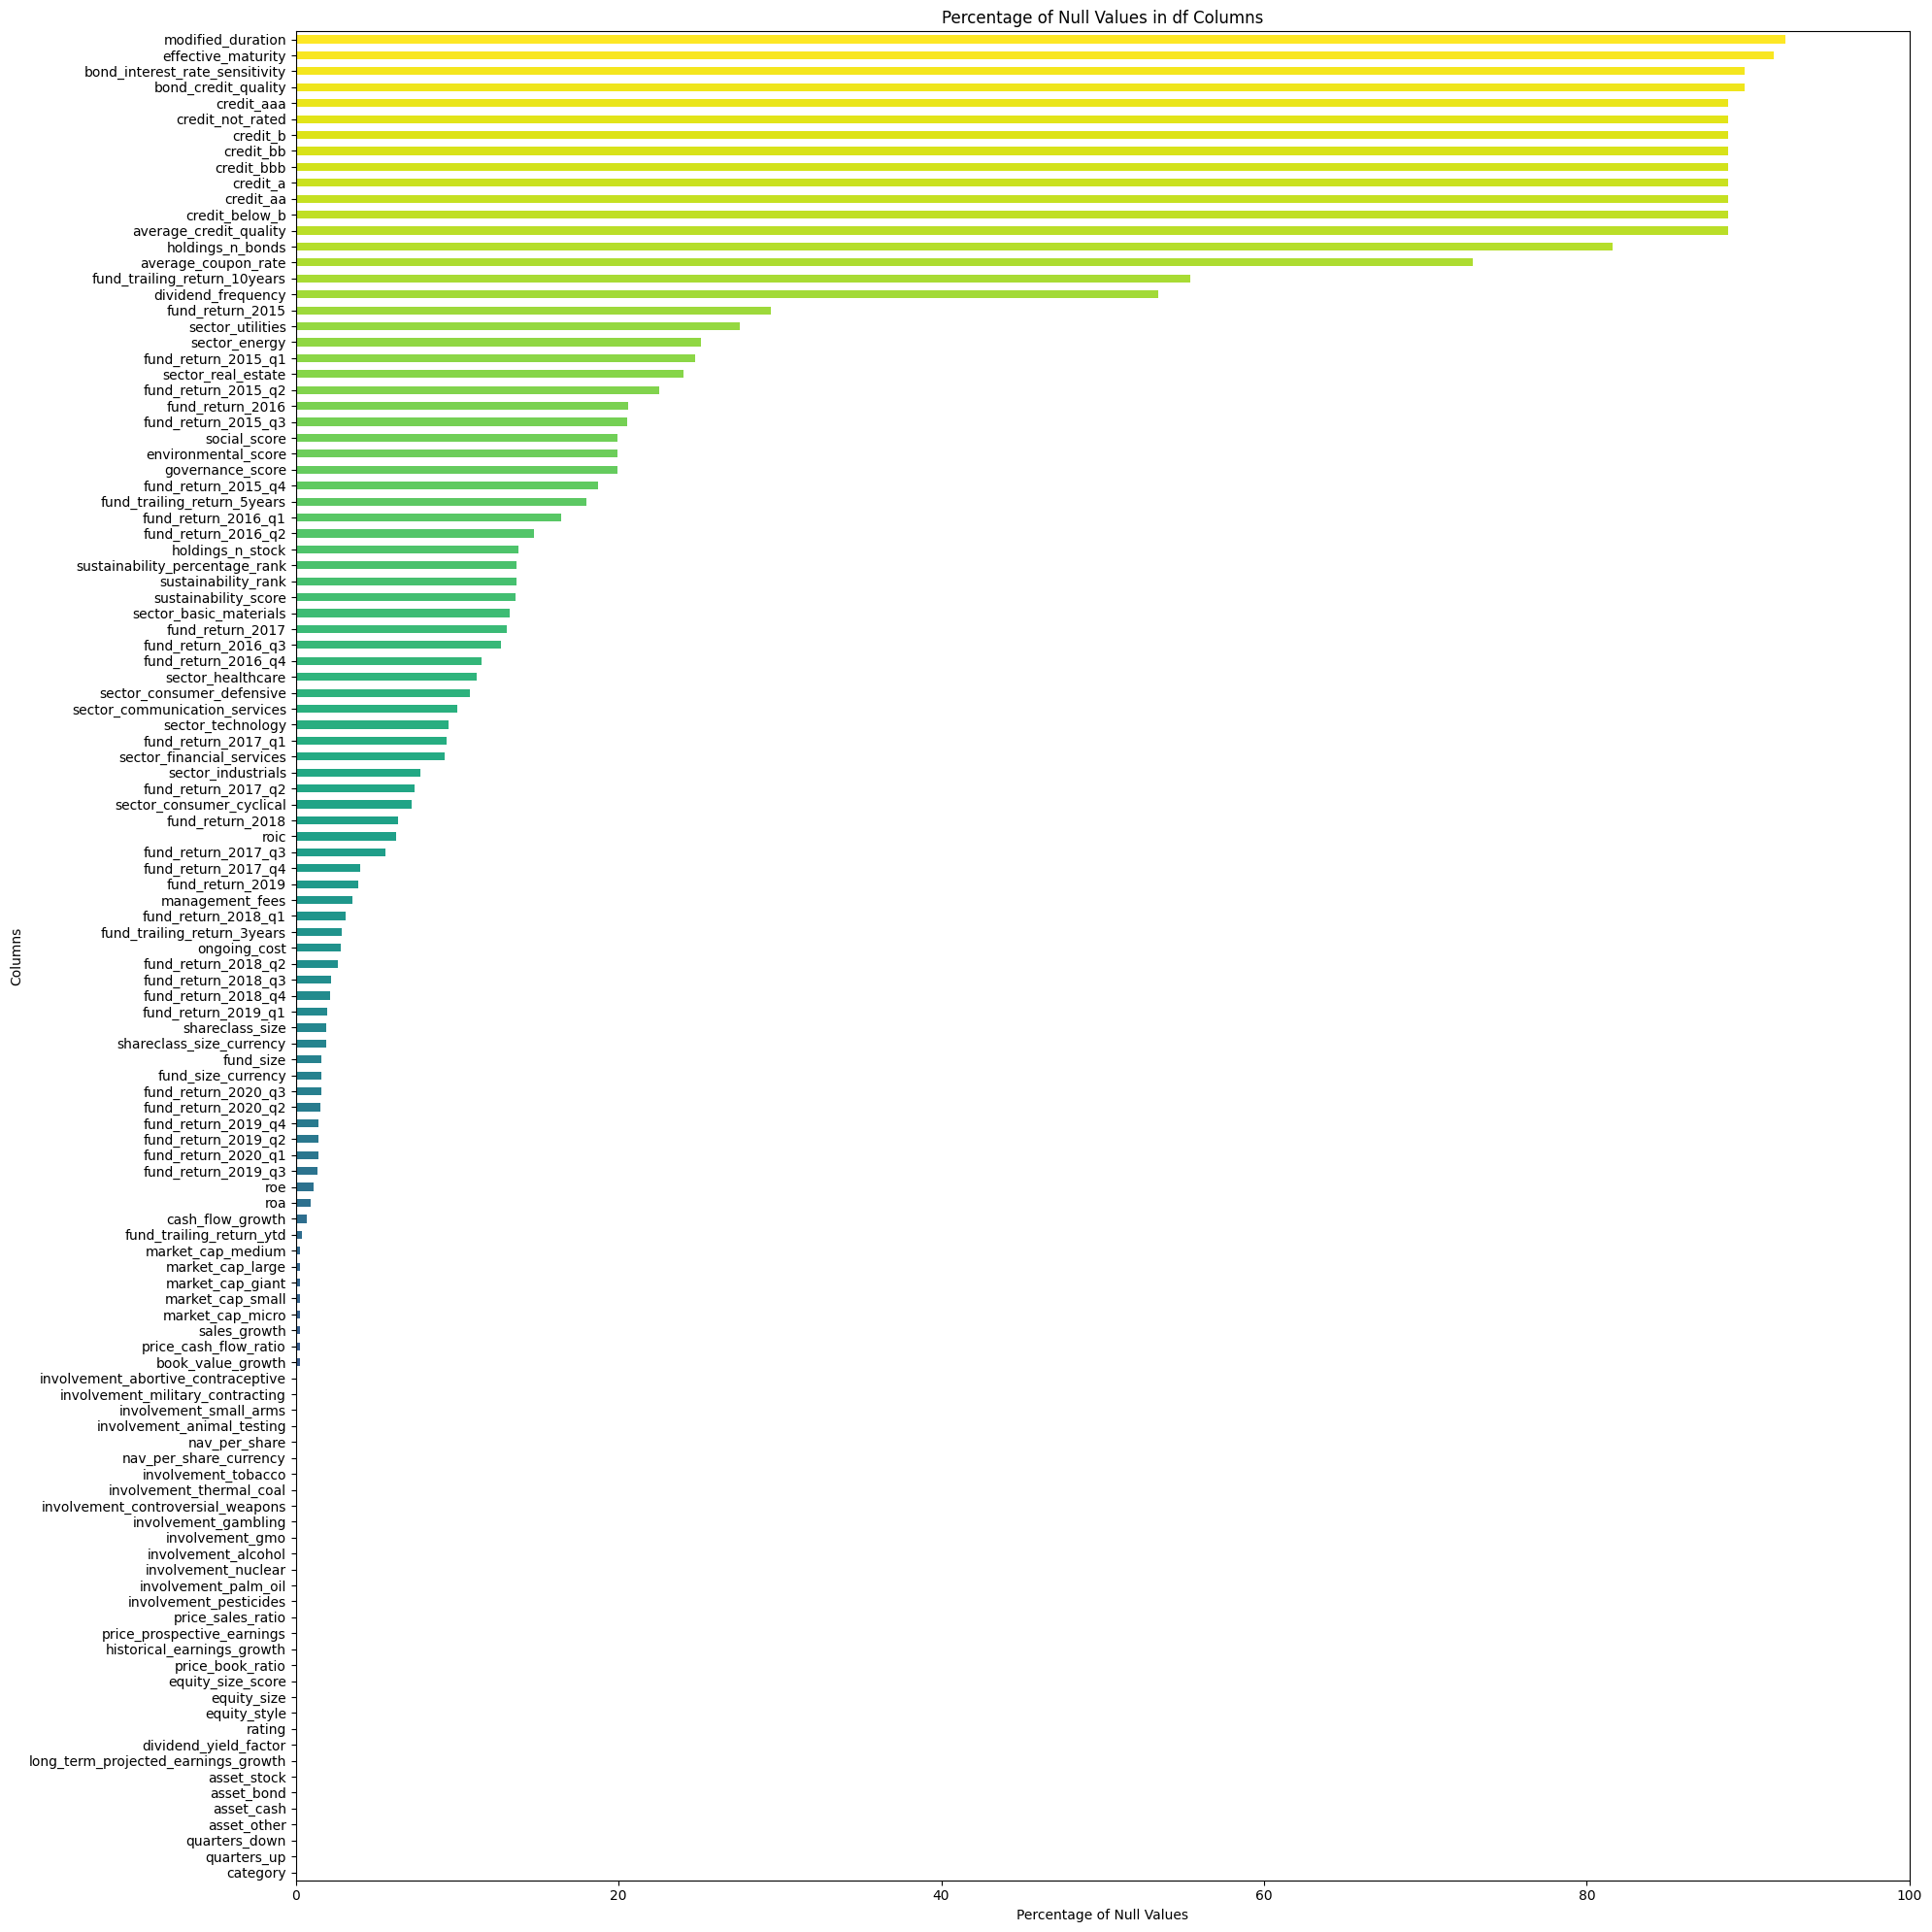

In [ ]:
barplot(train_df)

In [ ]:
dropped_train_df = drop_columns_with_nulls_over_threshold(train_df)

Because the null values of some of the columns exceeded 50%, which is a considerable amount of data, we are going to drop those columns.

# EDA

##  1. Mengetahui 5 besar Investment Management berdasarkan dana kelolaan (fund_size)

In [ ]:
df_sort_fundsize = dropped_train_df.copy()
unique_values = df_sort_fundsize['fund_size_currency'].unique()
unique_values

array(['NOK', 'USD', 'GBP', 'EUR', nan, 'CHF', 'JPY', 'CAD', 'HKD', 'SEK',
       'AUD', 'SGD', 'DKK', 'CNH'], dtype=object)

In [ ]:
#create a dictionary to get conversion rate to USD (data per 27 Aug 2023)
currency_to_usd = {
    'NOK': 0.099 ,
    'USD': 1,
    'GBP': 1.28,
    'EUR': 1.11,
    'CHF': 1.19,
    'JPY': 0.0071,
    'CAD' : 0.76,
    'HKD': 0.13,
    'SEK': 0.10,
    'AUD': 0.68,
    'SGD':0.76,
    'DKK': 0.15,
    'CNH' : 1.4
}

In [ ]:
df_currency = df_sort_fundsize.copy()
df_currency['usd_fund_size'] = None
for index, row in df_currency.iterrows():
    try:
        df_currency.at[index,'usd_fund_size'] = df_currency.at[index,'fund_size'] * currency_to_usd[df_currency.at[index,'fund_size_currency']]
    except:
        continue

In [ ]:
df_fund_sorted = df_currency.sort_values('usd_fund_size', ascending=False)
df_fund_sorted.head()

ticker                           category equity_style equity_size  \
6479   F00000YN9Y  Global Flexible Bond - GBP Hedged        Value      Medium   
17066  F00000OY3N  Global Flexible Bond - USD Hedged        Value      Medium   
10727  F00000SKYP  Global Flexible Bond - CHF Hedged        Value      Medium   
12387  F00000TYLI  Global Flexible Bond - EUR Hedged        Value      Medium   
14056  F00000OZZ4  Global Flexible Bond - USD Hedged        Value      Medium   

       equity_size_score  price_prospective_earnings  price_book_ratio  \
6479              116.43                        9.68               0.3   
17066             116.43                        9.68               0.3   
10727             116.43                        9.68               0.3   
12387             116.43                        9.68               0.3   
14056             116.43                        9.68               0.3   

       price_sales_ratio  price_cash_flow_ratio  dividend_yield_factor  \
6479                1.12                   11.1                    1.9   
17066               1.12                   11.1                    1.9   
10727               1.12                   11.1                    1.9   
12387               1.12                   11.1                    1.9   
14056               1.12                   11.1                    1.9   

       long_term_projected_earnings_growth  historical_earnings_growth  \
6479                                 17.21                      -32.66   
17066                                17.21                      -32.66   
10727                                17.21                      -32.66   
12387                                17.21                      -32.66   
14056                                17.21                      -32.66   

       sales_growth  cash_flow_growth  book_value_growth   roa  roe  roic  \
6479         -18.52              5.87              -6.36 -0.46 -5.6   NaN   
17066        -18.52              5.87              -6.36 -0.46 -5.6   NaN   
10727        -18.52              5.87              -6.36 -0.46 -5.6   NaN   
12387        -18.52              5.87              -6.36 -0.46 -5.6   NaN   
14056        -18.52              5.87              -6.36 -0.46 -5.6   NaN   

       asset_stock  asset_bond  asset_cash  asset_other  \
6479          0.85      122.73      -30.35         6.79   
17066         0.85      122.73      -30.35         6.79   
10727         0.85      122.73      -30.35         6.79   
12387         0.85      122.73      -30.35         6.79   
14056         0.85      122.73      -30.35         6.79   

       sector_basic_materials  sector_consumer_cyclical  \
6479                      NaN                     25.29   
17066                     NaN                     25.29   
10727                     NaN                     25.29   
12387                     NaN                     25.29   
14056                     NaN                     25.29   

       sector_financial_services  sector_real_estate  \
6479                        40.3               25.47   
17066                       40.3               25.47   
10727                       40.3               25.47   
12387                       40.3               25.47   
14056                       40.3               25.47   

       sector_consumer_defensive  sector_healthcare  sector_utilities  \
6479                         NaN                NaN              0.12   
17066                        NaN                NaN              0.12   
10727                        NaN                NaN              0.12   
12387                        NaN                NaN              0.12   
14056                        NaN                NaN              0.12   

       sector_communication_services  sector_energy  sector_industrials  \
6479                             8.8           0.02                 NaN   
17066                            8.8           0.02                 NaN   
10727          

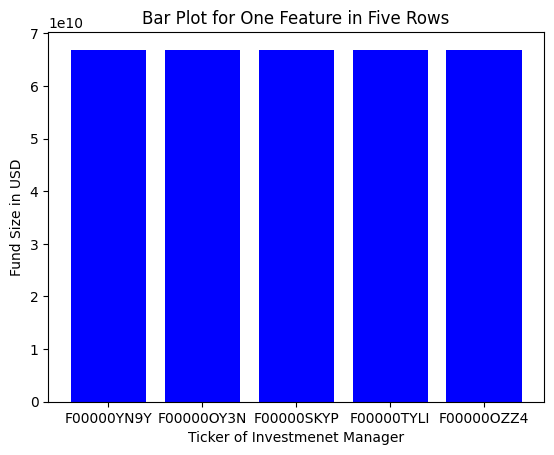

In [ ]:
# Plotting the bar plot for one feature
df_top_five = df_fund_sorted.head()
plt.bar(df_top_five['ticker'], df_top_five['usd_fund_size'], color='blue')

# Adding labels and title
plt.xlabel('Ticker of Investmenet Manager')
plt.ylabel('Fund Size in USD')
plt.title('Bar Plot for One Feature in Five Rows')

# Show the plot
plt.show()

## 2. Mengetahui perbandingan untuk tiap sektor (sector_*)

In [ ]:
sectors = [ 'sector_basic_materials', 'sector_consumer_cyclical', 'sector_financial_services',
           'sector_real_estate', 'sector_consumer_defensive', 'sector_healthcare', 'sector_utilities',
           'sector_communication_services', 'sector_energy', 'sector_industrials', 'sector_technology']
sector_data = dropped_train_df[sectors]
columns_to_exclude = ['rating', 'long_term_projected_earnings_growth']
columns_to_scale = [col for col in sector_data.columns if col not in columns_to_exclude]
data_to_scale = dropped_train_df[columns_to_scale]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_scale)

scaled_df = pd.DataFrame(scaled_data, columns = columns_to_scale)
scaled_df.index = dropped_train_df.index

scaled_df[columns_to_exclude]= dropped_train_df[columns_to_exclude]

scaled_df.head()



sector_basic_materials  sector_consumer_cyclical  \
3                -0.888843                  0.557871   
6                -0.593431                  1.486584   
11               -0.685445                 -0.162977   
14                0.084564                 -0.389911   
16                0.212899                 -0.801825   

    sector_financial_services  sector_real_estate  sector_consumer_defensive  \
3                   -0.369489           -0.503652                   0.463708   
6                   -0.694902            0.035832                  -0.317688   
11                  -0.374346           -0.931759                  -0.315621   
14                  -0.511958           -0.472327                  -0.437585   
16                   0.584084            1.699530                  -1.626217   

    sector_healthcare  sector_utilities  sector_communication_services  \
3           -0.085517         -0.781488                      -0.140896   
6           -1.191380         -1.097521                       0.964371   
11           0.371366         -0.996807                       0.775839   
14           0.471742         -1.010699                       1.367357   
16          -1.442319          0.270800                       0.115978   

    sector_energy  sector_industrials  sector_technology  rating  \
3       -0.149348            0.992813           0.098467     2.0   
6       -0.341685           -1.062723           1.650718     3.0   
11      -0.428931           -0.521697           1.502490     3.0   
14      -0.323839           -0.543411           0.871628     3.0   
16      -0.512211           -1.500610           2.447596     3.0   

    long_term_projected_earnings_growth  
3                                  7.77  
6                                 12.29  
11                                 9.91  
14                                 8.78  
16                                 7.05

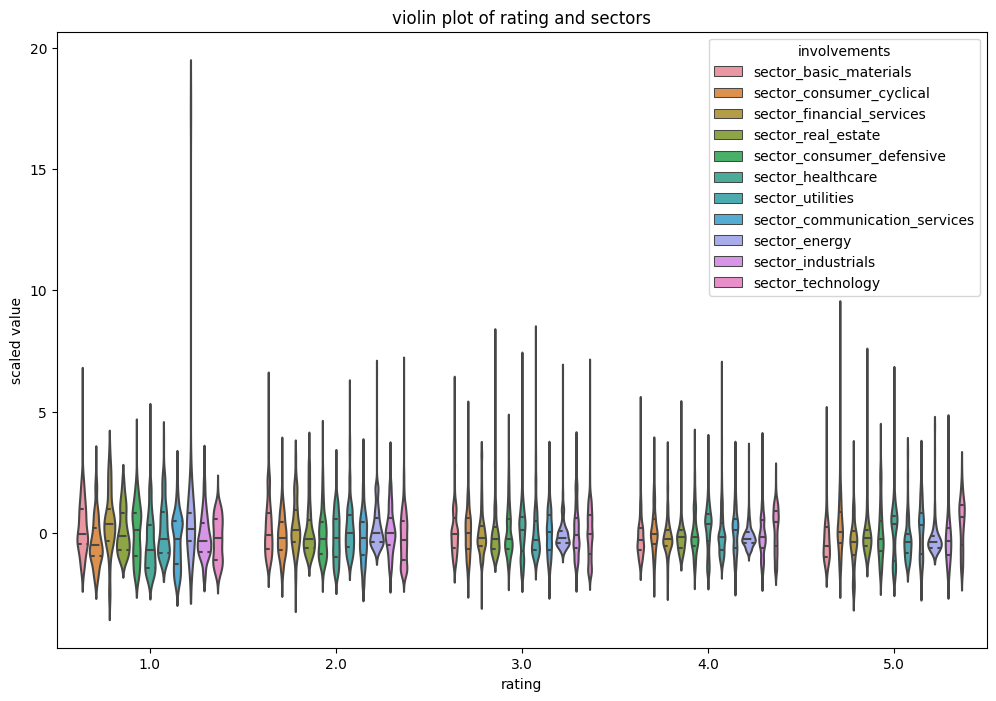

In [ ]:
columns_to_include =[ 'sector_basic_materials', 'sector_consumer_cyclical', 'sector_financial_services',
           'sector_real_estate', 'sector_consumer_defensive', 'sector_healthcare', 'sector_utilities',
           'sector_communication_services', 'sector_energy', 'sector_industrials', 'sector_technology', 'rating']


plot_data = scaled_df[columns_to_include]
# num_rows_to_sample = 200

# # Randomly sample rows from the DataFrame
# plot_data = plot_data.sample(n=num_rows_to_sample, random_state=42)  # Set a random seed for reproducibility


plt.figure(figsize=(12,8))
sns.violinplot(x='rating', y='value', hue='variable', data=plot_data.melt('rating'),inner='quart')
plt.title('violin plot of rating and sectors')
plt.xlabel('rating')
plt.ylabel('scaled value')
plt.legend(title='involvements')
plt.show()

## 3. Hubungan Management_fees dengan return investasi


Correlation: 0.02855912894997523


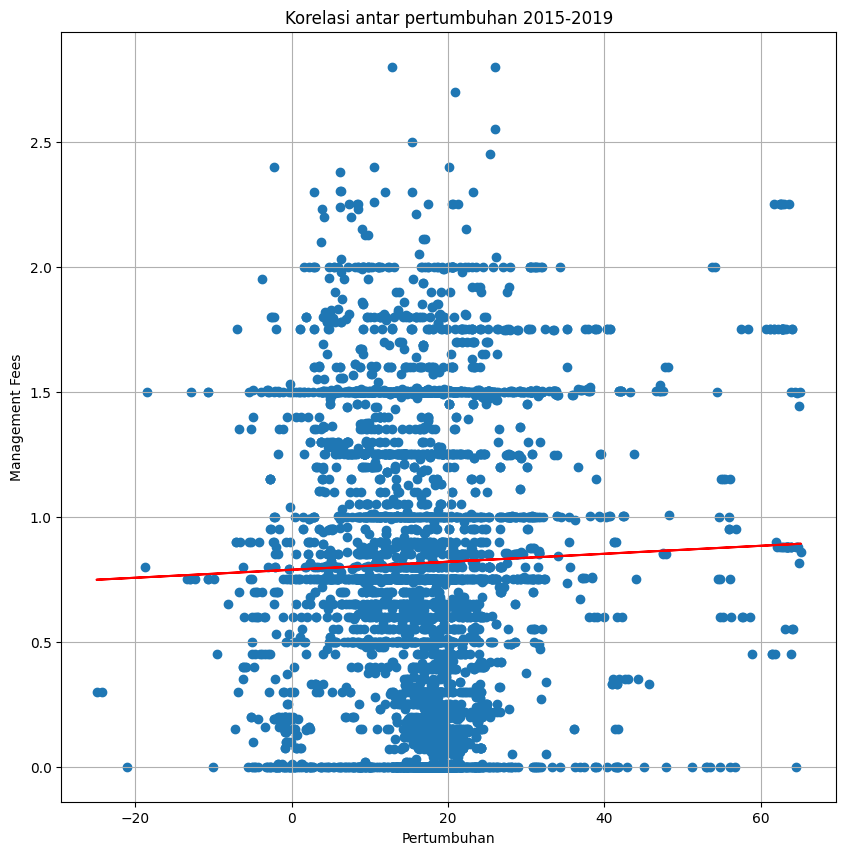

In [ ]:
growth = (dropped_train_df['fund_return_2019'] - dropped_train_df['fund_return_2015'])
print(f'Correlation: {growth.corr(dropped_train_df["management_fees"])}')

m, b = np.polyfit(growth, dropped_train_df['management_fees'], 1)

plt.figure(figsize=(10, 10))
plt.scatter(growth, dropped_train_df['management_fees'])
plt.plot(growth, m * growth + b, color='red', label='Fit Line')
plt.title('Korelasi antar pertumbuhan 2015-2019')
plt.xlabel('Pertumbuhan')
plt.ylabel('Management Fees')
plt.grid(True)
plt.show()


## 4. Perbedaan Equity Style

In [ ]:
financial_metrics = []
for column in dropped_train_df.columns:
    if column[:5] == "price":
        financial_metrics.append(column)

financial_metrics

['price_prospective_earnings',
 'price_book_ratio',
 'price_sales_ratio',
 'price_cash_flow_ratio']

In [ ]:
financial_metrics.append("equity_style")

In [ ]:
financial_df = dropped_train_df[financial_metrics]
financial_df.head()

price_prospective_earnings  price_book_ratio  price_sales_ratio  \
3                        17.19              1.77               0.75   
6                        16.16              1.77               1.45   
11                       24.06              2.95               2.63   
14                       21.12              3.33               2.65   
16                       15.45              1.42               1.06   

    price_cash_flow_ratio equity_style  
3                    6.52        Value  
6                    3.86        Blend  
11                  12.38        Blend  
14                  14.49        Blend  
16                   5.27        Value

In [ ]:
sector_data = financial_df[financial_metrics]
columns_to_exclude = ["equity_style"]

columns_to_scale = [col for col in sector_data.columns if col not in columns_to_exclude]

data_to_scale = dropped_train_df[columns_to_scale]

# Create a StandardScaler
financialScaler = StandardScaler()

# Fit and transform the data using the scaler
financial_scaled_data = financialScaler.fit_transform(data_to_scale)

# Create a DataFrame with the scaled values and the same column names
financial_scaled_df = pd.DataFrame(financial_scaled_data, columns=columns_to_scale)
financial_scaled_df.index = financial_df.index

# Add back the columns that were excluded from scaling
financial_scaled_df[columns_to_exclude] = financial_df[columns_to_exclude]

# Display the scaled DataFrame
financial_scaled_df.head()


price_prospective_earnings  price_book_ratio  price_sales_ratio  \
3                    -0.022524         -0.149573          -1.066933   
6                    -0.260925         -0.149573           0.015759   
11                    1.567586          1.342053           1.840869   
14                    0.887102          1.822407           1.871803   
16                   -0.425259         -0.592004          -0.587455   

    price_cash_flow_ratio equity_style  
3               -0.543294        Value  
6               -1.359157        Blend  
11               1.254057        Blend  
14               1.901227        Blend  
16              -0.926688        Value

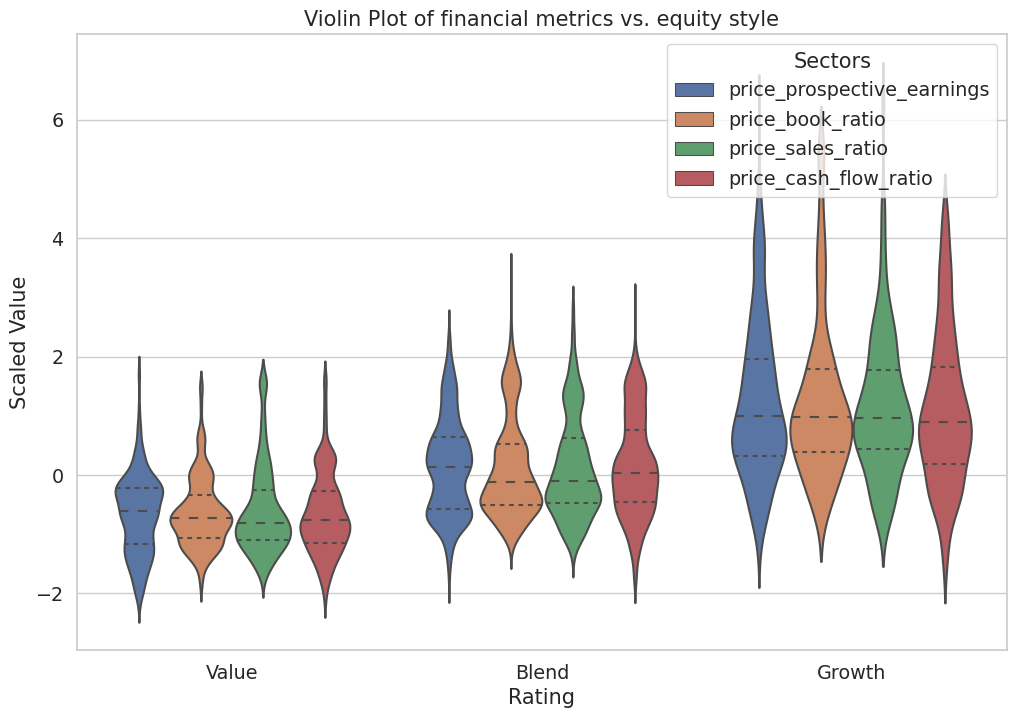

In [ ]:
sns.set(style="whitegrid", font_scale=1.25)


# Define the columns you want to include in the violin plot
columns_to_include = ["price_prospective_earnings",	"price_book_ratio",	"price_sales_ratio","price_cash_flow_ratio", "equity_style"]

# Create a new DataFrame with the selected columns
plot_data = financial_scaled_df[columns_to_include]

# Create a violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(x="equity_style", y="value", hue="variable", data=plot_data.melt("equity_style"), inner="quart")
plt.title("Violin Plot of financial metrics vs. equity style")
plt.xlabel("Rating")
plt.ylabel("Scaled Value")
plt.legend(title="Sectors")
plt.show()

## 5. Mencari hubungan keterlibatan pada bisnis produce yang kontroversial dengan rating

In [ ]:
columns_to_scale = ['involvement_abortive_contraceptive', 'involvement_alcohol','involvement_animal_testing','involvement_controversial_weapons', 'involvement_gambling',
                     'involvement_gmo','involvement_military_contracting', 'involvement_nuclear', 'involvement_palm_oil', 'involvement_pesticides', 'involvement_small_arms',
                     'involvement_thermal_coal', 'involvement_tobacco']
columns_to_ex = [col for col in dropped_train_df.columns if col not in columns_to_scale ]

data_to_scale = dropped_train_df[columns_to_scale]
scaler= StandardScaler()

scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns = columns_to_scale)
scaled_df.index = dropped_train_df.index
scaled_df[columns_to_ex] = dropped_train_df[columns_to_ex]
scaled_df.head()

involvement_abortive_contraceptive  involvement_alcohol  \
3                             0.098557            -0.758907   
6                            -1.450248            -0.372235   
11                           -0.158524            -0.824260   
14                            1.091056            -0.824260   
16                           -1.450248            -0.824260   

    involvement_animal_testing  involvement_controversial_weapons  \
3                    -0.306052                           0.542224   
6                    -1.230702                          -0.717786   
11                   -0.136651                           1.032228   
14                    0.356429                           1.137229   
16                   -1.347670                           0.857226   

    involvement_gambling  involvement_gmo  involvement_military_contracting  \
3              -0.266167         0.141258                          0.988730   
6              -0.567543        -0.191128                         -0.379365   
11             -0.567543         4.351481                          0.469117   
14             -0.567543        -0.191128                          0.548046   
16              6.859903        -0.191128                         -0.846359   

    involvement_nuclear  involvement_palm_oil  involvement_pesticides  \
3             -0.270876             -0.236799               -0.259277   
6             -0.780941             -0.236799               -0.473457   
11            -0.780941             -0.236799                1.693542   
14            -0.621546             -0.236799               -0.473457   
16            -0.780941             -0.236799               -0.473457   

    involvement_small_arms  involvement_thermal_coal  involvement_tobacco  \
3                -0.175952                 -0.584096            -0.287564   
6                 0.179691                 -1.006119             0.992512   
11                0.440496                 -0.628781             0.174376   
14               -0.661998                 -1.006119            -0.632628   
16               -0.661998                  0.960013            -0.632628   

        ticker                             category equity_style equity_size  \
3   F000005K32            US Large-Cap Blend Equity        Value       Large   
6   F000000LIL                 Asia ex-Japan Equity        Blend       Large   
11  F00000N6ZP            US Large-Cap Blend Equity        Blend       Large   
14  F00000MJKD            US Large-Cap Blend Equity        Blend       Large   
16  F0GBR0550U  Asia-Pacific ex-Japan Equity Income        Value       Large   

    equity_size_score  price_prospective_earnings  price_book_ratio  \
3              229.67                       17.19              1.77   
6              369.24                       16.16              1.77   
11             309.51                       24.06              2.95   
14             326.65                       21.12              3.33   
16             325.58                       15.45              1.42   

    price_sales_ratio  price_cash_flow_ratio  dividend_yield_factor  \
3                0.75                   6.52                   2.73   
6                1.45                   3.86                   2.91   
11               2.63                  12.38                   1.58   
14               2.65                  14.49                   1.85   
16               1.06                   5.27                   4.22   

    long_term_projected_earnings_growth  historical_earnings_growth  \
3                                  7.77                        3.17   
6                                 12.29                        9.37   
11                                 9.91                       16.04   
14                                 8.78                       17.27   
16                                 7.05                       -1.60   

    sales_growth  cash_flow_growth  book_value_growth   roa    roe   ro

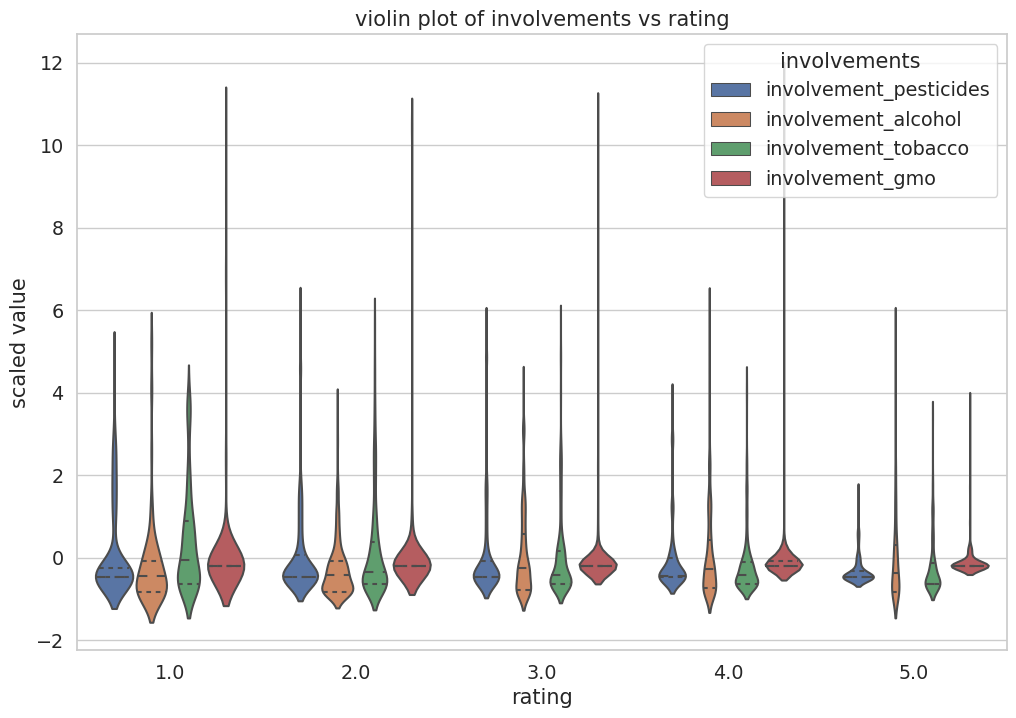

In [ ]:
columns_to_include = ['involvement_pesticides', 'involvement_alcohol',
                      'involvement_tobacco', 'involvement_gmo', 'rating']

plot_data = scaled_df[columns_to_include]

plt.figure(figsize=(12,8))
sns.violinplot(x='rating', y='value', hue='variable', data=plot_data.melt('rating'),inner='quart')
plt.title('violin plot of involvements vs rating')
plt.xlabel('rating')
plt.ylabel('scaled value')
plt.legend(title='involvements')
plt.show()

## hubungan involvement pada bisnis senjata kontroversial dan return on investment rate

In [ ]:
# Get the mean and median of the column
mean_value = dropped_train_df['roic'].mean()
median_value = dropped_train_df['roic'].median()
print(f'the mean and media for roic is {mean_value} and {median_value}')

the mean and media for roic is 10.766092402464064 and 11.03


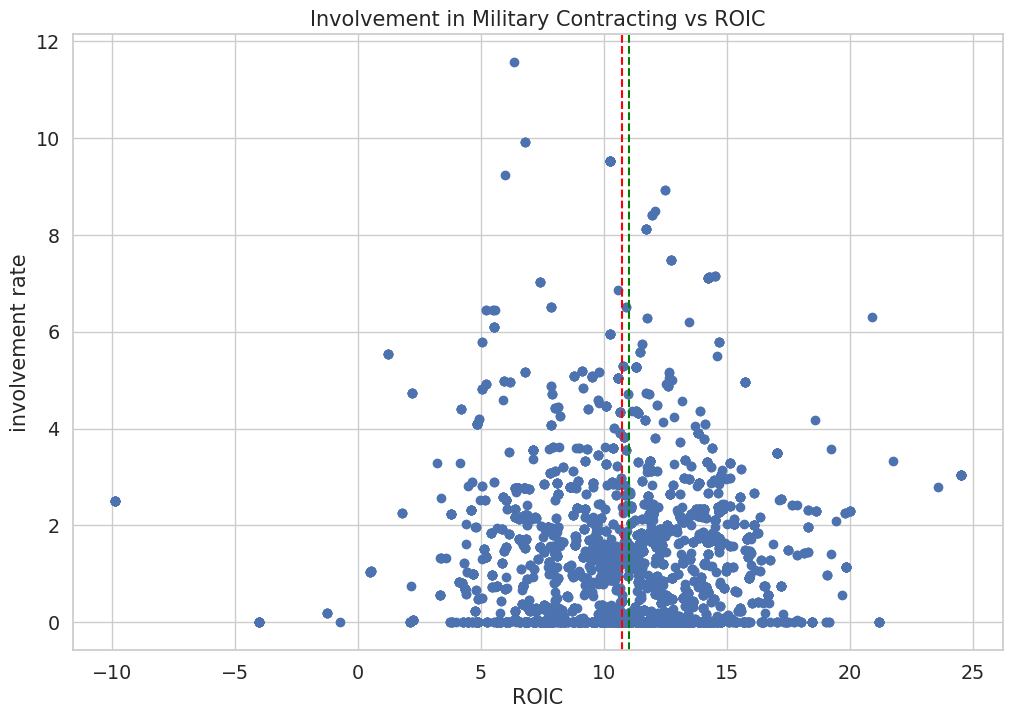

In [ ]:
# Add labels and a title
plt.figure(figsize=(12,8))
plt.scatter(dropped_train_df['roic'], dropped_train_df['involvement_military_contracting'], label='Scatter Plot')

plt.title('Involvement in Military Contracting vs ROIC')
plt.xlabel('ROIC')
plt.ylabel('involvement rate')
plt.axvline(x=mean_value, color='red', linestyle='--', label='roic mean')
plt.axvline(x=median_value, color='green', linestyle='--', label='roic median')
plt.show()

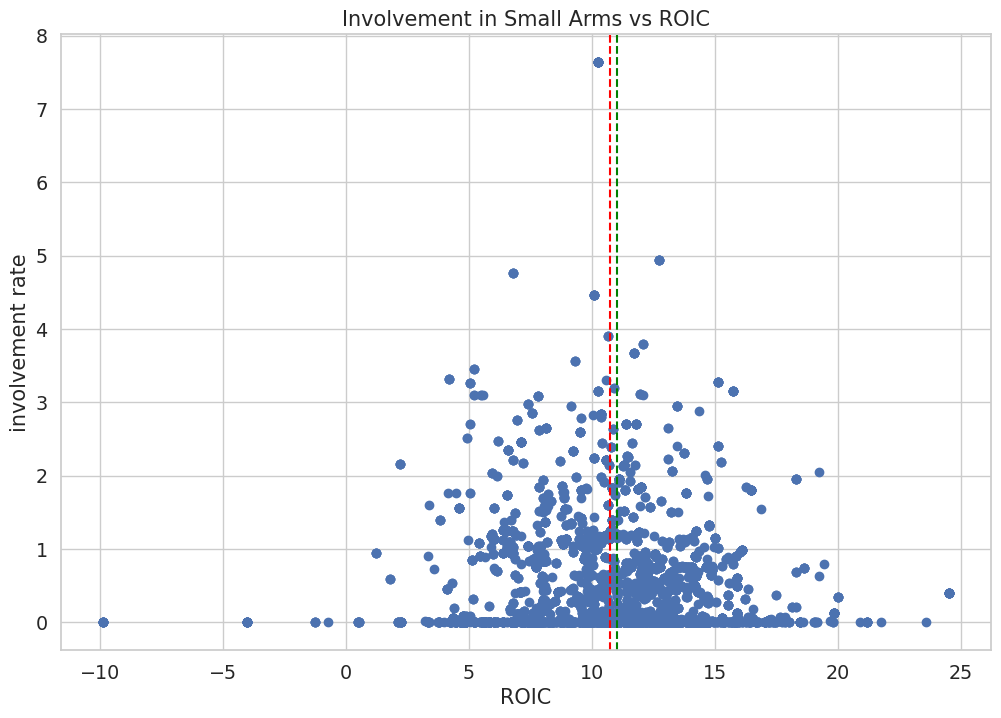

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(dropped_train_df['roic'], dropped_train_df['involvement_small_arms'], label='Scatter Plot')

plt.title('Involvement in Small Arms vs ROIC')
plt.xlabel('ROIC')
plt.ylabel('involvement rate')
plt.axvline(x=mean_value, color='red', linestyle='--', label='roic mean')
plt.axvline(x=median_value, color='green', linestyle='--', label='roic median')


plt.show()

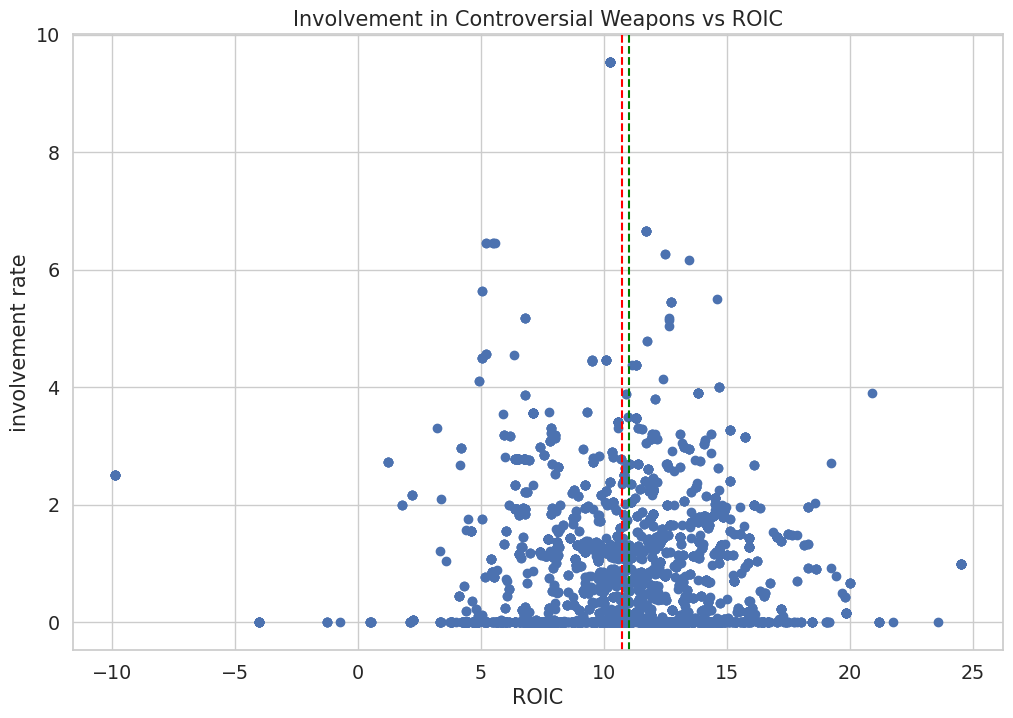

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(dropped_train_df['roic'], dropped_train_df['involvement_controversial_weapons'], label='Scatter Plot')

plt.title('Involvement in Controversial Weapons vs ROIC')
plt.xlabel('ROIC')
plt.ylabel('involvement rate')
plt.axvline(x=mean_value, color='red', linestyle='--', label='roic mean')
plt.axvline(x=median_value, color='green', linestyle='--', label='roic median')


plt.show()

# Encoding Categorical Feature



Using ordinal encoder to encode categorical column with the mean order of 'rating'

In [ ]:
test_df.head()

ticker                       category dividend_frequency equity_style  \
0  F00000ZI14  Global Large-Cap Blend Equity           Annually        Blend   
1  F00000Z00F        GBP Flexible Allocation           Annually        Blend   
2  F0GBR04LI4            Europe ex-UK Equity           Annually        Blend   
3  F00000XGZ9            US Small-Cap Equity                NaN        Value   
4  F0GBR04HV5     Property - Indirect Global          Quarterly        Blend   

  equity_size  equity_size_score  price_prospective_earnings  \
0       Large             268.51                       18.85   
1       Large             306.01                       22.41   
2       Large             237.10                       13.28   
3       Small              32.58                       13.85   
4      Medium             180.89                       25.22   

   price_book_ratio  price_sales_ratio  price_cash_flow_ratio  \
0              2.48               1.35                   8.13   
1              2.35               1.72                   9.87   
2              1.32               0.94                   3.74   
3              1.12               0.75                   5.14   
4              1.38               4.20                   7.11   

   dividend_yield_factor  long_term_projected_earnings_growth  \
0                   2.48                                 8.20   
1                   2.16                                10.00   
2                   3.97                                 8.60   
3                   2.78                                10.77   
4                   3.48                                 7.01   

   historical_earnings_growth  sales_growth  cash_flow_growth  \
0                        6.90          4.74              5.15   
1                        6.60          5.46              5.39   
2                        1.81          1.83             10.77   
3                        5.18          3.46              9.02   
4                        5.45          7.40             13.33   

   book_value_growth    roa    roe   roic bond_interest_rate_sensitivity  \
0               6.39  10.05  26.31  16.61                            NaN   
1               6.22   8.33  23.29  13.39                           High   
2               1.92   8.47  18.40  15.66                            NaN   
3               5.97   2.26   5.72   4.57                            NaN   
4               7.76   3.85   9.11    NaN                            NaN   

  bond_credit_quality  average_coupon_rate  average_credit_quality  \
0                 NaN                  NaN                     NaN   
1                High                 2.69                     3.0   
2                 NaN                  NaN                     NaN   
3                 NaN                  NaN                     NaN   
4                 NaN                  NaN                     NaN   

   modified_duration  effective_maturity  asset_stock  asset_bond  asset_cash  \
0                NaN                 NaN        99.85        0.00       -0.98   
1              14.73               12.46        81.45       15.31        3.23   
2                NaN                 NaN        96.27        0.00        3.73   
3                NaN                 NaN        99.17        0.00        0.83   
4                NaN                 NaN        97.45        0.00        2.55   

   asset_other  sector_basic_materials  sector_consumer_cyclical  \
0         1.13                    1.15                     11.59   
1         0.01                    8.07                     22.45   
2         0.00                    6.04                      6.70   
3         0.00                    7.44                     18.98   
4         0.00                     NaN                      1.77   

   sector_financial_services  sector_real_estate  sector_consumer_defensive  \
0                      10.51                2.97                       2.99   
1                      13.90        

In [ ]:
# Possible to rearrange
# ticker_group = dropped_train_df.groupby(by='ticker')['rating'].mean().sort_values(ascending=True).index.tolist()
category_group = [np.nan] + dropped_train_df.groupby(by='category')['rating'].mean().sort_values(ascending=True).index.tolist()
equity_style_group = [np.nan] + dropped_train_df.groupby(by='equity_style')['rating'].mean().sort_values(ascending=True).index.tolist()
equity_size_group = [np.nan] + dropped_train_df.groupby(by='equity_size')['rating'].mean().sort_values(ascending=True).index.tolist()
nav_per_share_currency_group = [np.nan] + dropped_train_df.groupby(by='nav_per_share_currency')['rating'].mean().sort_values(ascending=True).index.tolist()
shareclass_size_currency_group = [np.nan] + dropped_train_df.groupby(by='shareclass_size_currency')['rating'].mean().sort_values(ascending=True).index.tolist()
fund_size_currency_group = [np.nan] + dropped_train_df.groupby(by='fund_size_currency')['rating'].mean().sort_values(ascending=True).index.tolist()

column_to_encode = ['category','equity_style','equity_size', 'nav_per_share_currency', 'shareclass_size_currency', 'fund_size_currency']

enc = OrdinalEncoder(categories=[category_group, equity_style_group, equity_size_group, nav_per_share_currency_group, shareclass_size_currency_group, fund_size_currency_group])
dropped_train_df[column_to_encode] = enc.fit_transform(dropped_train_df[column_to_encode])


In [ ]:
test_df[column_to_encode] = enc.transform(test_df[column_to_encode])

ValueError: ignored

In [ ]:
dropped_train_df.head()

In [ ]:
test_df.head()

In [ ]:
dropped_train_df.head()

# Input missing value using K nearest neighboor

In [ ]:
from sklearn.impute import KNNImputer

# Exclude columns related to "C02 Emission" from the imputation process
columns_to_exclude = ['rating']  # Add the actual column names you want to exclude

# Create a KNNImputer with 5 neighbors
imputer = KNNImputer(n_neighbors=5)

# Filter the columns to exclude from the imputation
columns_for_imputation = [col for col in dropped_train_df.columns if col not in columns_to_exclude]

# Fit and transform the DataFrame
ready_df_imputed = dropped_train_df.copy()
ready_df_imputed[columns_for_imputation] = imputer.fit_transform(dropped_train_df[columns_for_imputation])

# Convert the NumPy array back to a pandas DataFrame with the original column names
ready_df_imputed = pd.DataFrame(ready_df_imputed, columns=dropped_train_df.columns)

In [ ]:
def count_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count the number of outliers
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return len(outliers)

In [ ]:
count_outliers(ready_df_imputed["fund_size"])

2637

In [ ]:
count_outliers(ready_df_imputed["shareclass_size"])

3328

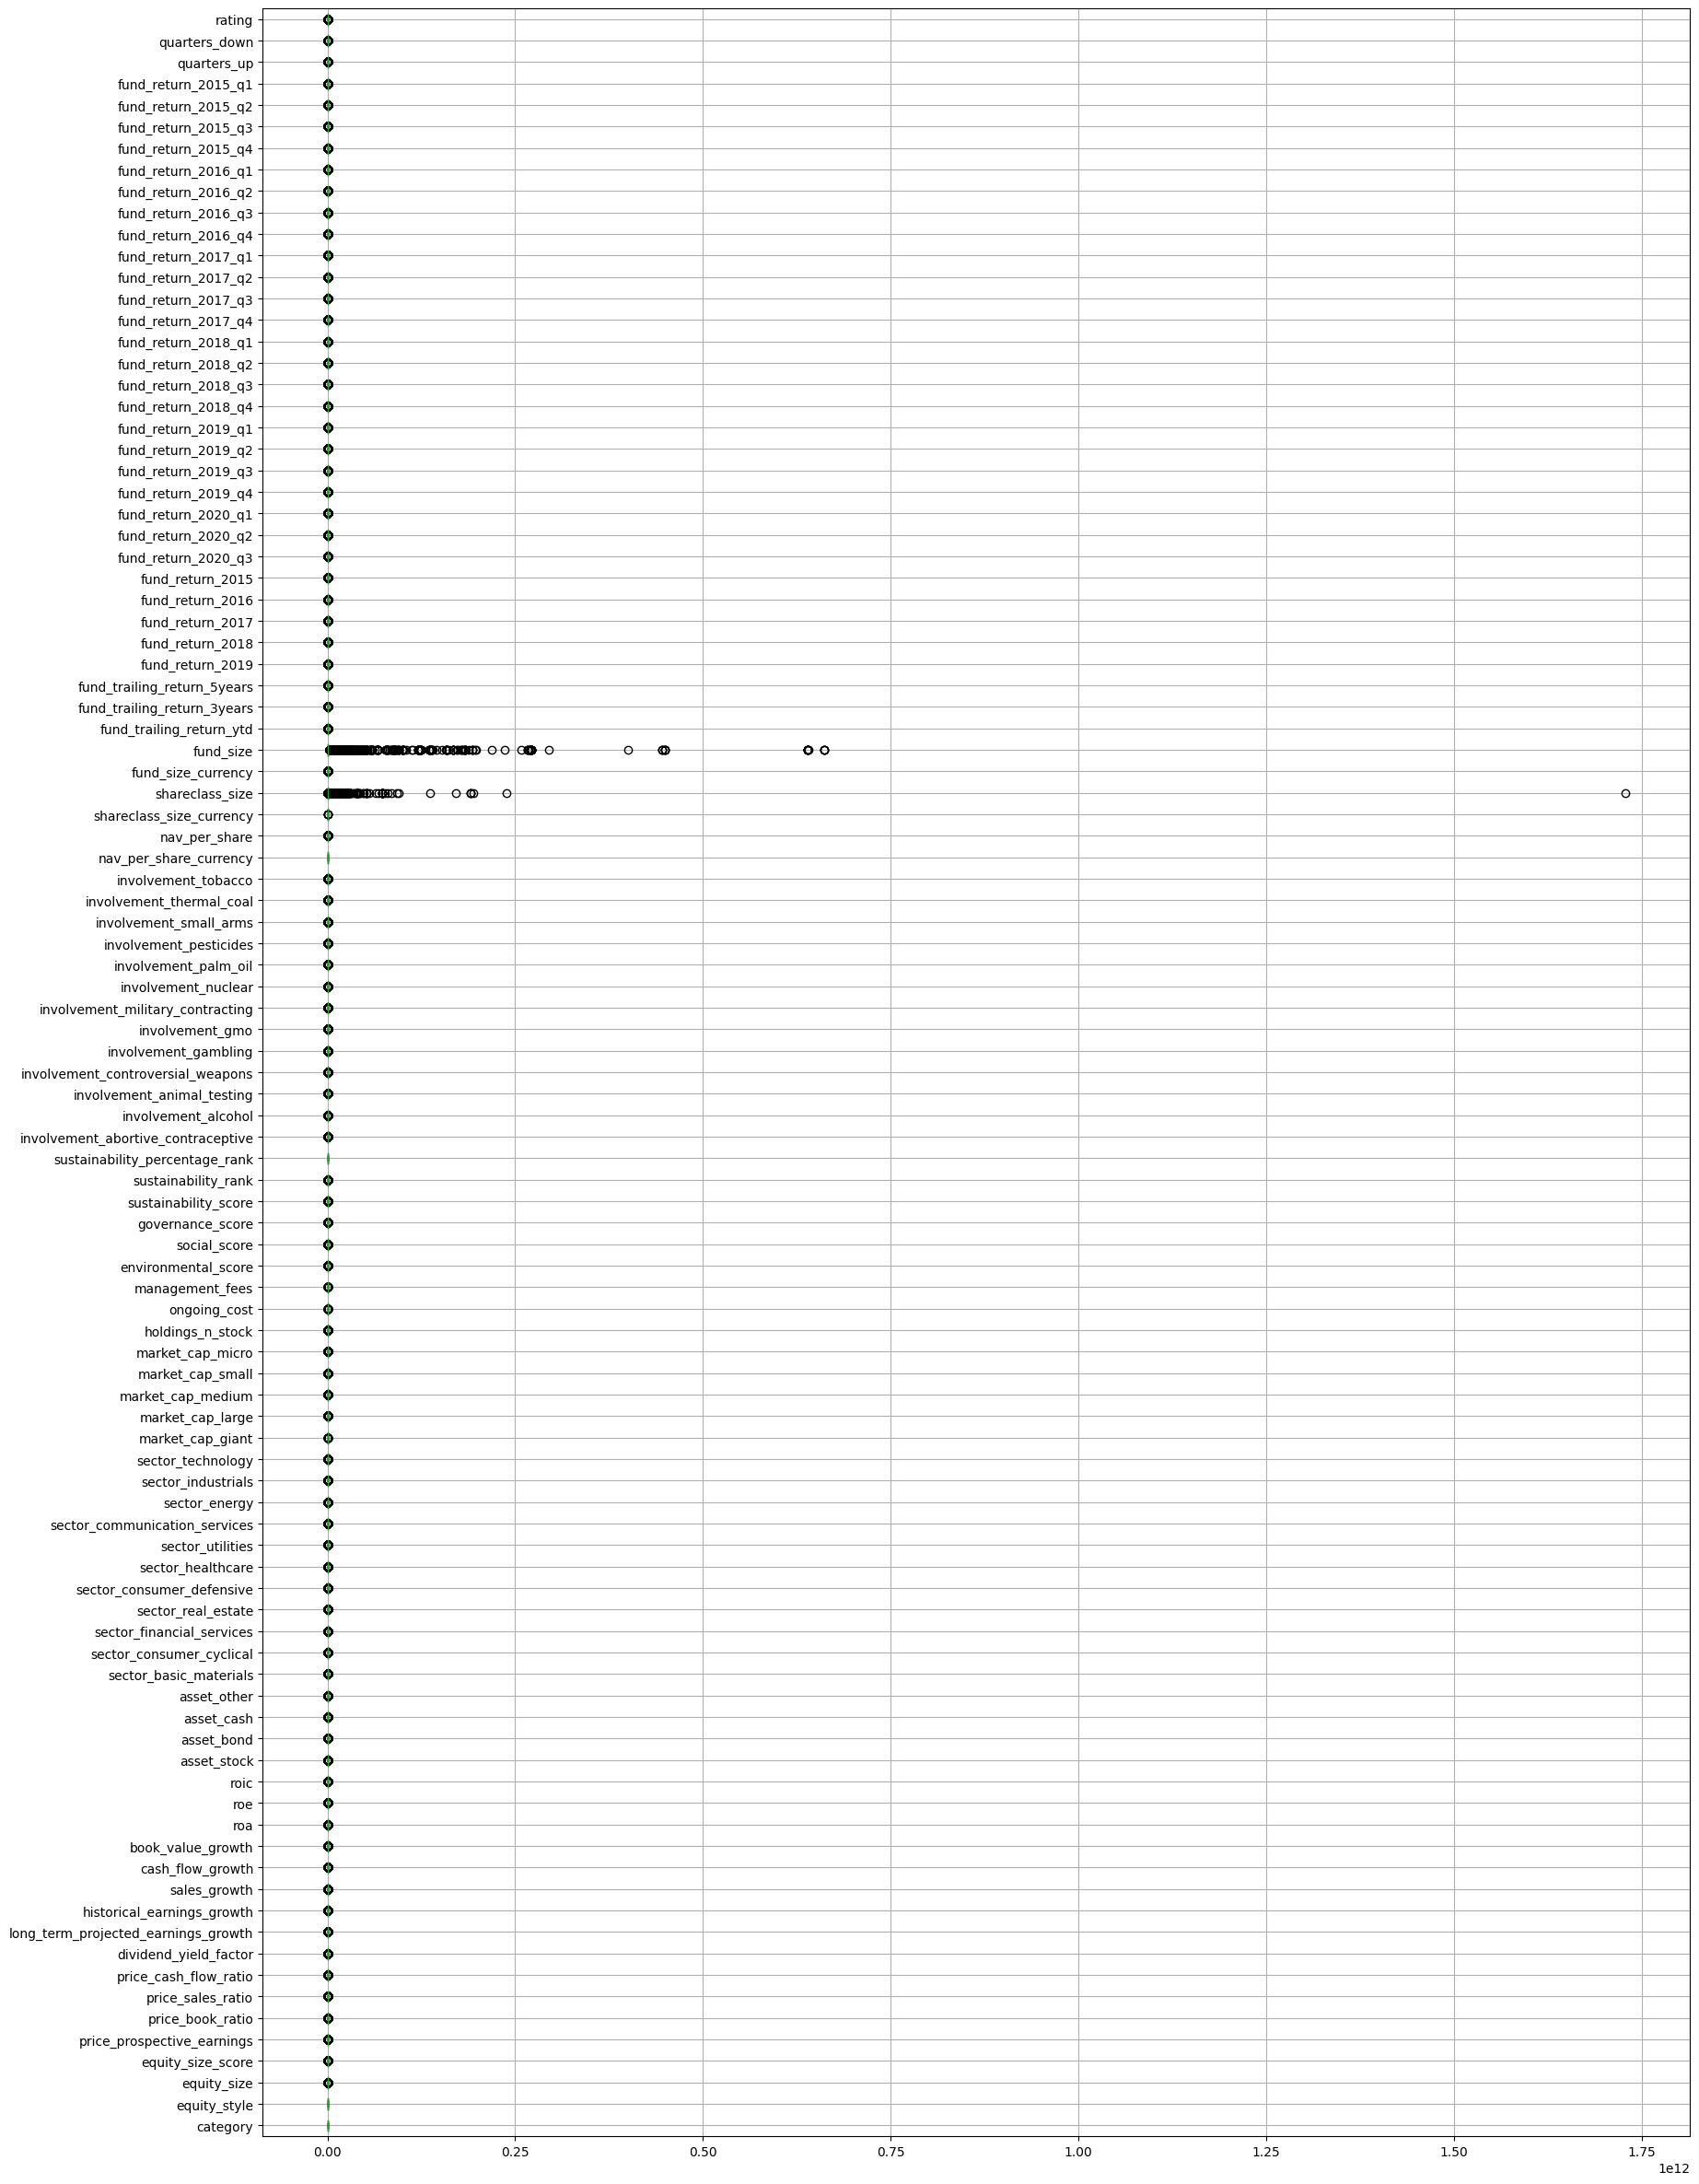

In [ ]:
ready_df_imputed.boxplot(vert=False, figsize=(20,30))
plt.show()

In [ ]:
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove rows with outliers
    df_cleaned = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return df_cleaned

In [ ]:
ready_df_imputed = remove_outliers(ready_df_imputed, 'shareclass_size')

In [ ]:
ready_df_imputed = remove_outliers(ready_df_imputed, 'fund_size')

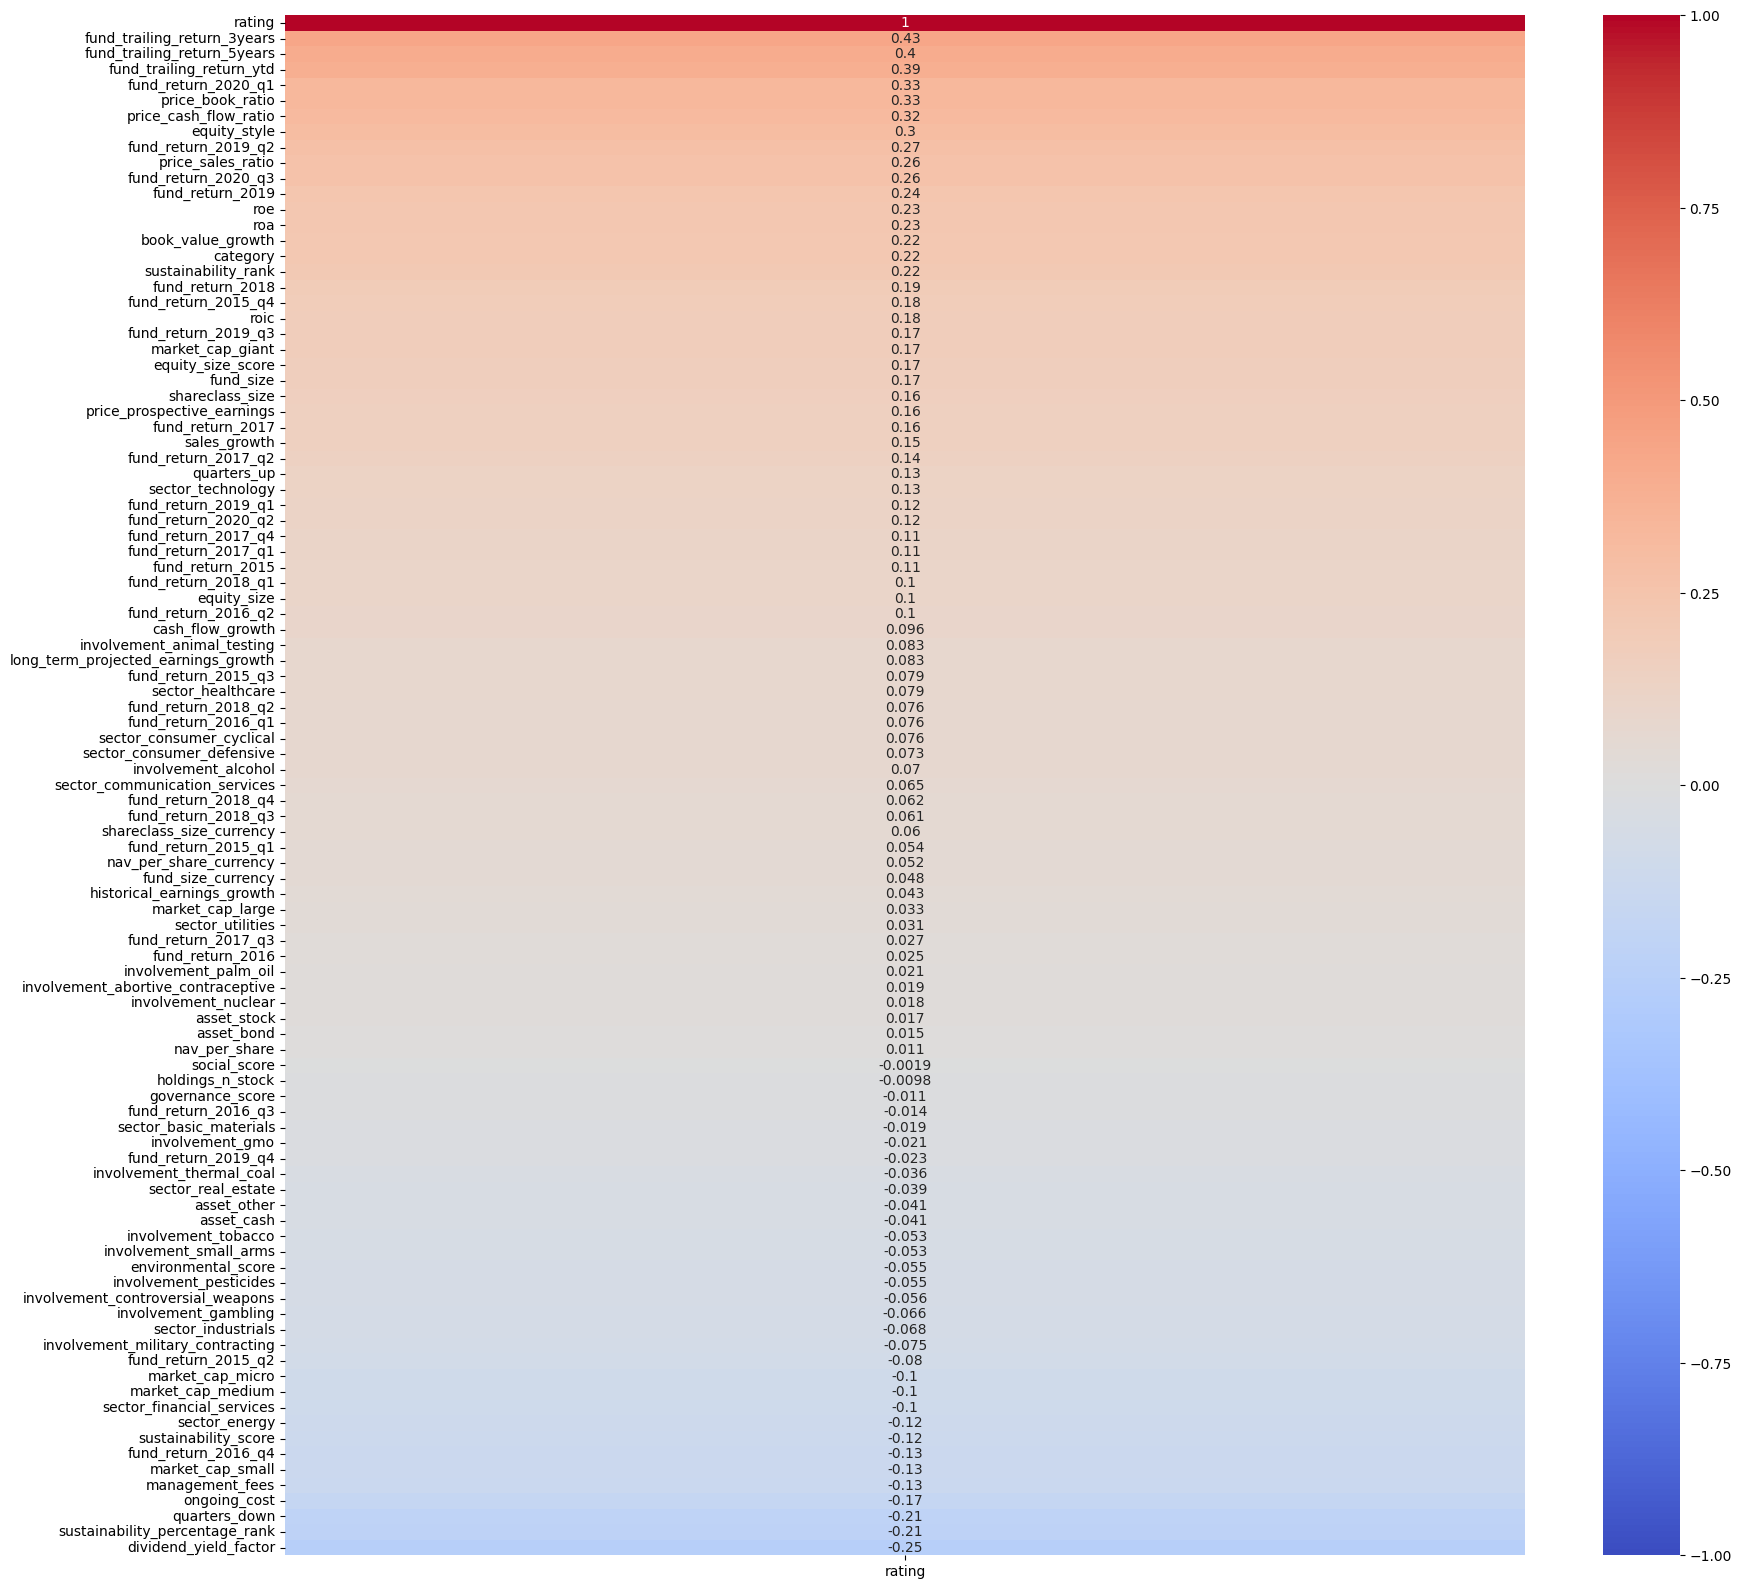

In [ ]:
plt.figure(figsize=(20, 20))
correlation_matrix = ready_df_imputed.corr()
sns.heatmap(correlation_matrix[['rating']].sort_values(by='rating', ascending=False),
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1)
plt.show()

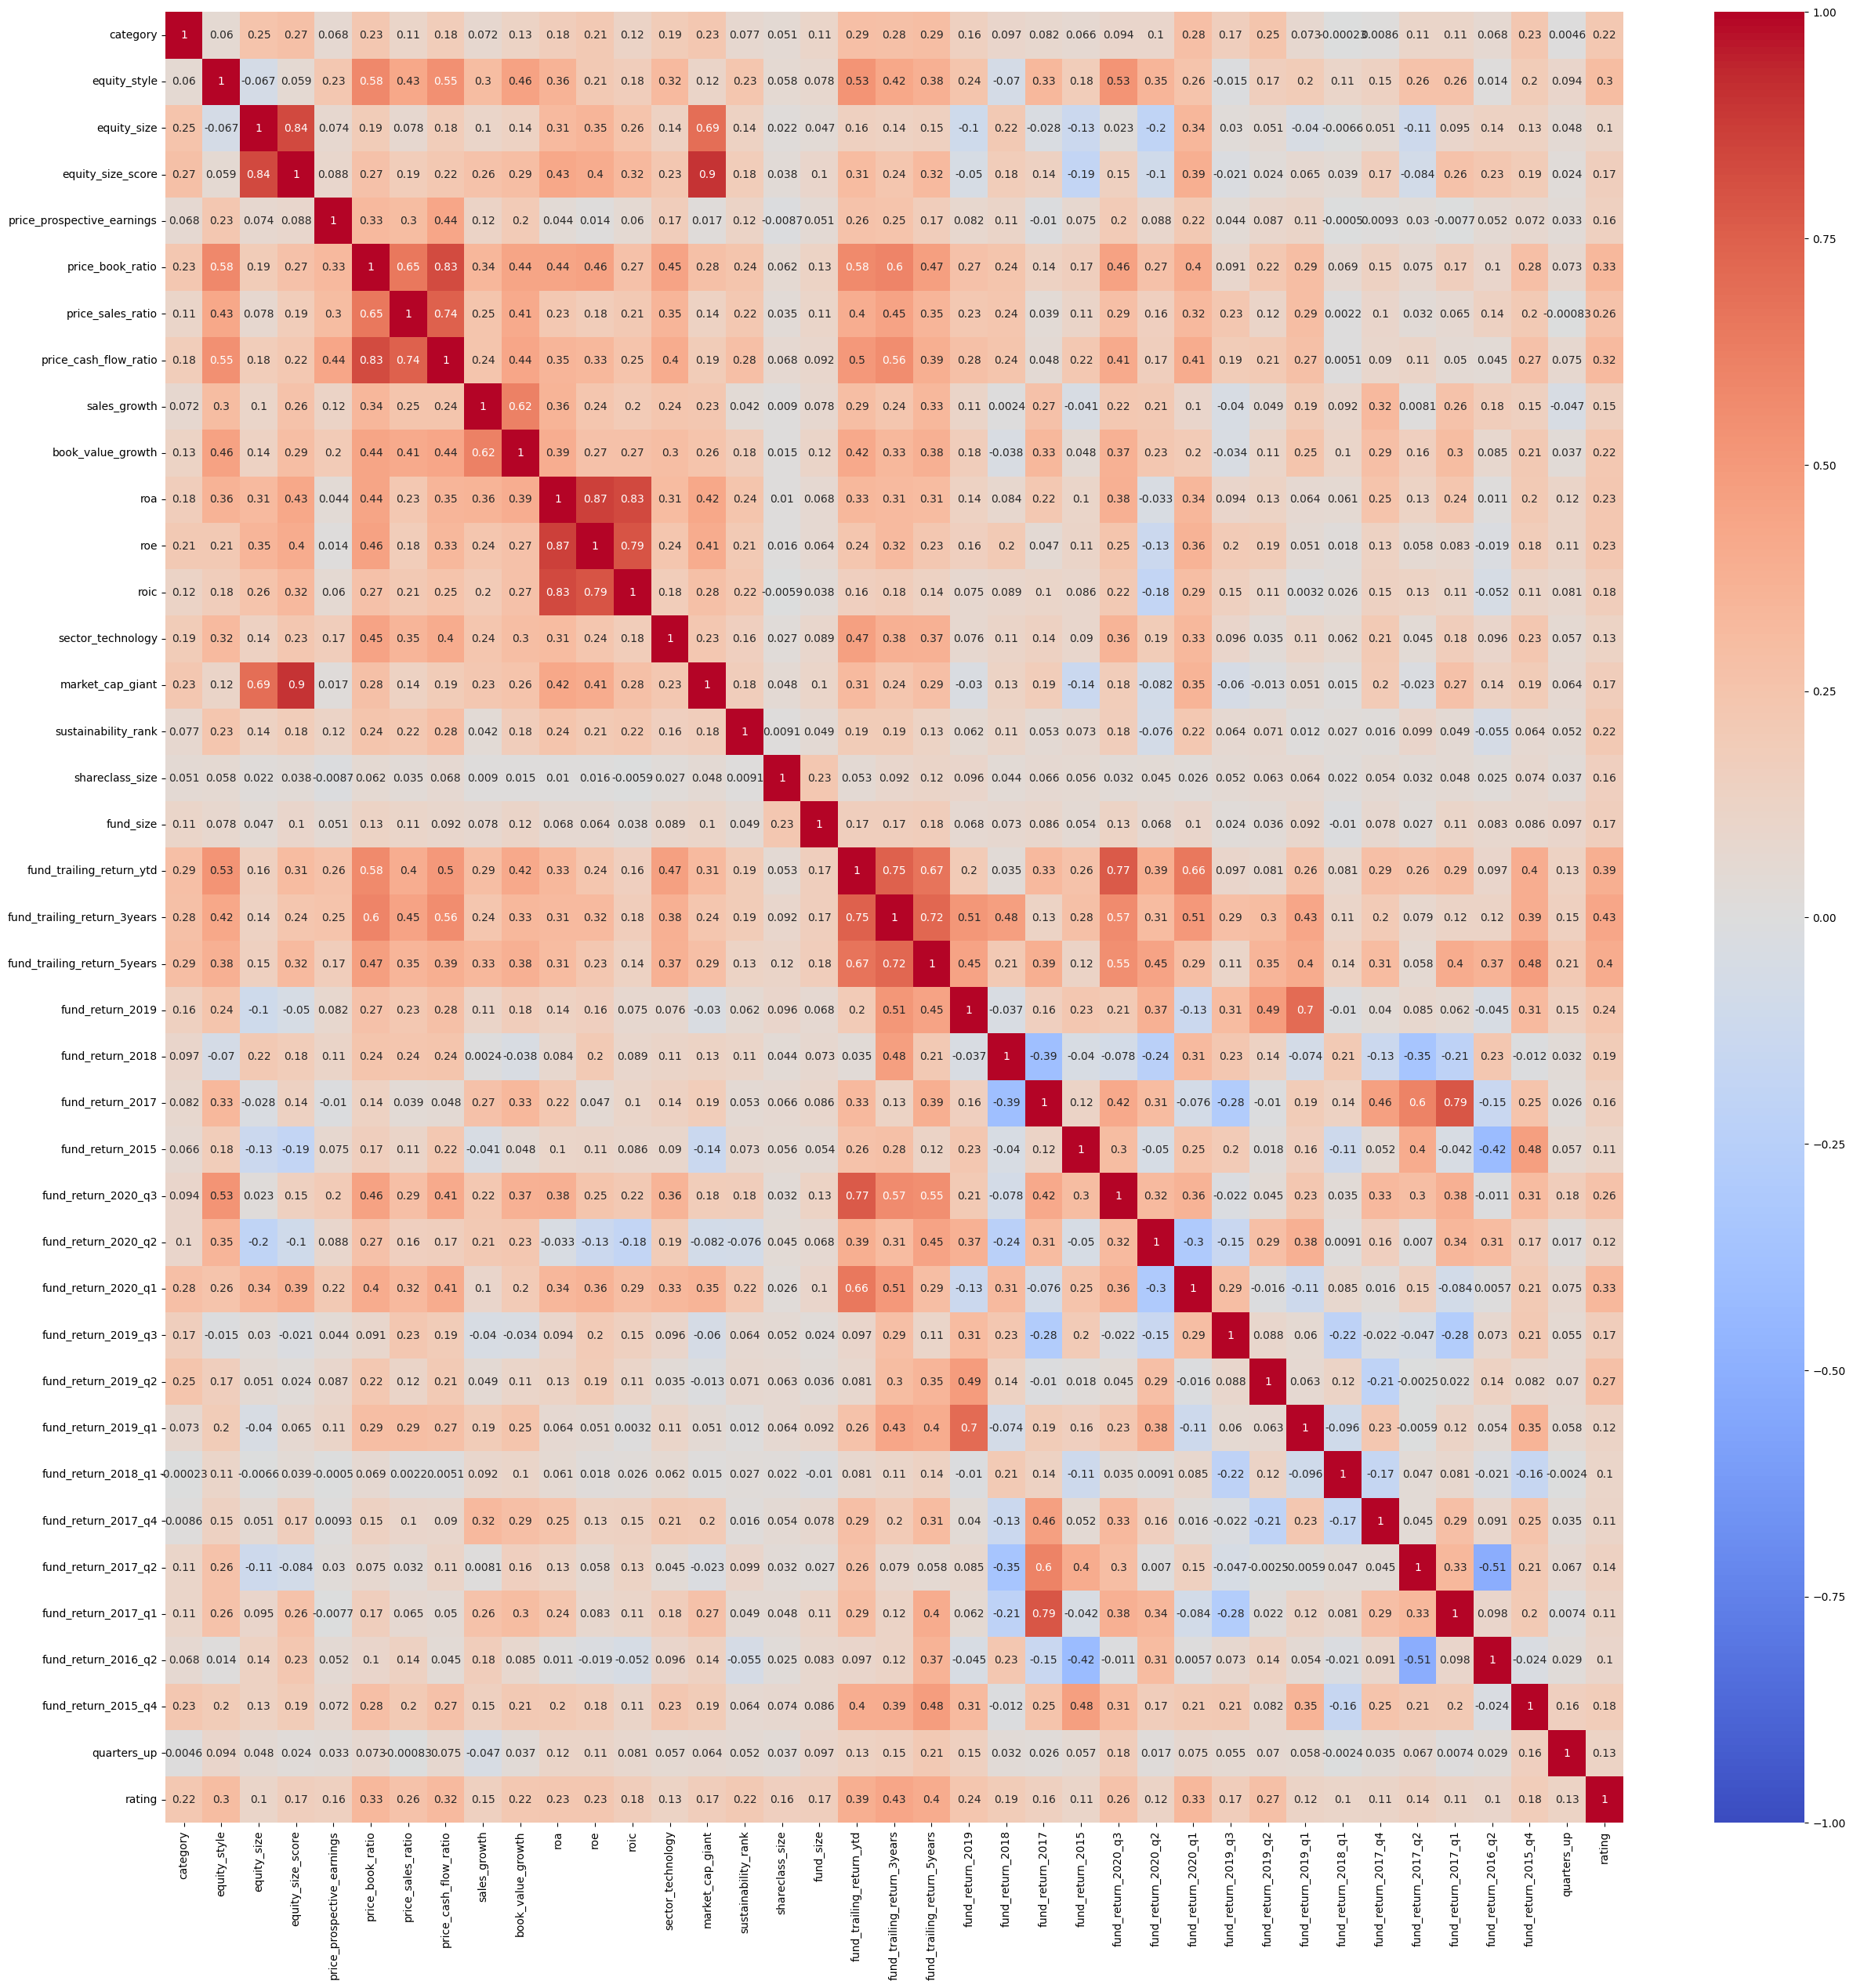

In [ ]:
# Assuming your DataFrame is named 'ready_df_imputed'
plt.figure(figsize=(30, 30))

# Calculate the correlation matrix
correlation_matrix = ready_df_imputed.corr()

# Specify the threshold for correlation below which columns will be removed
threshold = 0.1

# Identify columns with correlations below the threshold
low_correlation_columns = correlation_matrix[correlation_matrix['rating'] < threshold].index.tolist()

# Remove the low correlation columns from the DataFrame
ready_df_filtered = ready_df_imputed.drop(low_correlation_columns, axis=1)

# Create a heatmap of the filtered correlation matrix
sns.heatmap(ready_df_filtered.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.show()

Based on the heatmap above, we can see that some feature has a very high corelation so we can just choose one of them (not implemented)

In [ ]:
# columns_remove = ["maket_cap_giant", "roe"]

In [ ]:
ready_df_filtered.shape

(16802, 39)

In [ ]:
scaler = StandardScaler()

# Memisahkan antara fitur dan target
y = ready_df_filtered['rating']
X = ready_df_filtered.drop(['rating'],axis=1)

# Scaling the features using StandardScaler
X = scaler.fit_transform(X)
# X_test = scaler.transform(test_df)

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
ready_df_filtered.head()

category  equity_style  equity_size  equity_size_score  \
1      35.0           2.0          2.0             124.69   
2      98.0           3.0          3.0             322.70   
3     129.0           1.0          3.0             229.67   
4     132.0           3.0          2.0             111.36   
7     144.0           2.0          3.0             275.85   

   price_prospective_earnings  price_book_ratio  price_sales_ratio  \
1                       23.06              1.97               1.70   
2                       27.99              3.04               2.71   
3                       17.19              1.77               0.75   
4                       12.15              1.01               0.62   
7                       16.36              1.96               1.39   

   price_cash_flow_ratio  sales_growth  book_value_growth   roa    roe   roic  \
1                  12.07          7.55               9.59  7.36  14.61  11.33   
2                  10.35         13.80              14.76  7.83  16.35  11.62   
3                   6.52          3.04               1.86  4.68  17.51   8.65   
4                   3.54        -16.23              -2.83  1.86   7.77   2.02   
7                  10.36          2.44               6.97  7.65  19.48  12.52   

   sector_technology  market_cap_giant  sustainability_rank  shareclass_size  \
1              21.39              1.14                  2.0       17010000.0   
2              23.42             62.38                  4.0       30900000.0   
3              15.68             30.86                  2.0        6940000.0   
4              10.28             -0.08                  2.0        1190000.0   
7              18.70             37.43                  3.6        1900000.0   

     fund_size  fund_trailing_return_ytd  fund_trailing_return_3years  \
1  771790000.0                      1.65                         6.66   
2  128280000.0                     45.43                        13.19   
3  297460000.0                      3.61                         7.43   
4   18800000.0                     -1.86                         2.22   
7   99240000.0                      5.24                         3.95   

   fund_trailing_return_5years  fund_return_2019  fund_return_2018  \
1                       12.090             25.39             -5.72   
2                       18.480             22.29            -19.51   
3                       12.890             23.37             -6.10   
4                        8.582             20.20            -13.60   
7                        7.630              7.26              0.14   

   fund_return_2017  fund_return_2015  fund_return_2020_q3  \
1             1.740             7.120                 0.89   
2            29.120            -5.990                17.13   
3             6.130            -0.800                 4.01   
4            13.394            10.408                 1.36   
7             0.810             3.940                -2.69   

   fund_return_2020_q2  fund_return_2020_q1  fund_return_2019_q3  \
1                17.82               -24.09                 4.68   
2                27.23                -9.07                 1.42   
3                16.15               -22.56                 4.38   
4                27.48               -27.51                -1.85   
7                10.74                -3.82                 5.02   

   fund_return_2019_q2  fund_return_2019_q1  fund_return_2018_q1  \
1                 8.60                10.16                -5.35   
2                 3.90                 8.82                -9.37   
3                 5.28                11.49                -6.65   
4                11.95                 5.87                -6.92   
7                 5.41                 2.93                -4.65   

   fund_return_2017_q4  fund_return_2017_q2  fund_return_2017_q1  \
1                 5.29               -1.710                0.120   
2                 9.92                6.430                9

In [ ]:
ready_df_filtered['rating'].unique()

array([3., 4., 2., 5., 1.])

In [ ]:
catboost_params={
    'nan_mode': 'Min',
 'eval_metric': 'MultiClass',
 'iterations': 50,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'eval_fraction': 0,
 'l2_leaf_reg': 10,
 'random_strength': 0.30000001192092896,
 'rsm': 1,
 'boost_from_average': False,
 'use_best_model': False,
 'class_names': [1, 2, 3, 4, 5],
 'random_seed': 123,
 'depth': 5,
 'posterior_sampling': False,
 'border_count': 254,
 'bagging_temperature': 1,
 'classes_count': 5,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'MultiClass',
 'learning_rate': 0.4000000059604645,
 'score_function': 'Cosine',
 'task_type': 'CPU',
 'leaf_estimation_iterations': 1,
 'bootstrap_type': 'Bayesian',
 'max_leaves': 32
 }

In [ ]:
basic_params = {
    'iterations': 100,
    'learning_rate': 0.1,
    'eval_metric': 'MultiClass',
    'random_seed': 123,
    'loss_function': 'MultiClass'
}

In [ ]:
ccl = CatBoostClassifier(**catboost_params)
ccl.fit(X_train, y_train)
clas_result = ccl.predict(X_test)

0:	learn: 1.4412878	total: 63.1ms	remaining: 3.09s
1:	learn: 1.3523185	total: 74.1ms	remaining: 1.78s
2:	learn: 1.2999211	total: 87.1ms	remaining: 1.36s
3:	learn: 1.2613831	total: 100ms	remaining: 1.15s
4:	learn: 1.2363320	total: 111ms	remaining: 995ms
5:	learn: 1.2184840	total: 120ms	remaining: 883ms
6:	learn: 1.1965294	total: 131ms	remaining: 805ms
7:	learn: 1.1837788	total: 143ms	remaining: 753ms
8:	learn: 1.1688725	total: 154ms	remaining: 700ms
9:	learn: 1.1570764	total: 164ms	remaining: 657ms
10:	learn: 1.1465553	total: 176ms	remaining: 623ms
11:	learn: 1.1365297	total: 188ms	remaining: 595ms
12:	learn: 1.1280197	total: 200ms	remaining: 570ms
13:	learn: 1.1161608	total: 211ms	remaining: 542ms
14:	learn: 1.1113460	total: 222ms	remaining: 518ms
15:	learn: 1.1023715	total: 232ms	remaining: 494ms
16:	learn: 1.0953402	total: 241ms	remaining: 468ms
17:	learn: 1.0866324	total: 252ms	remaining: 449ms
18:	learn: 1.0788633	total: 262ms	remaining: 428ms
19:	learn: 1.0686298	total: 272ms	rema

In [ ]:
accuracy = accuracy_score(y_test, clas_result)
class_report = classification_report(y_test, clas_result)
conf_matrix = confusion_matrix(y_test, clas_result)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.5852424873549539
Classification Report:
               precision    recall  f1-score   support

         1.0       0.82      0.46      0.59       245
         2.0       0.59      0.53      0.56       705
         3.0       0.57      0.76      0.65      1263
         4.0       0.56      0.51      0.53       811
         5.0       0.63      0.34      0.44       337

    accuracy                           0.59      3361
   macro avg       0.63      0.52      0.55      3361
weighted avg       0.60      0.59      0.58      3361

Confusion Matrix:
 [[113 101  26   5   0]
 [ 18 376 288  18   5]
 [  5 131 954 155  18]
 [  2  25 330 411  43]
 [  0   9  69 146 113]]


# Regression

## Pre Processing


In [ ]:
categorical_cols = dropped_train_df.select_dtypes(include=['object']).columns
train_unique_values = dropped_train_df[categorical_cols].apply(lambda col: col.nunique())
train_unique_values

category                    196
equity_style                  3
equity_size                   3
nav_per_share_currency       17
shareclass_size_currency     15
fund_size_currency           13
dtype: int64

In [ ]:
test_unique_values = dropped_test_df[categorical_cols].apply(lambda col: col.nunique())
test_unique_values

category                    154
equity_style                  3
equity_size                   3
nav_per_share_currency       16
shareclass_size_currency     13
fund_size_currency           12
dtype: int64

In [ ]:
category_counts = dropped_train_df['category'].value_counts(normalize=True)
dropped_train_df['category'] = dropped_train_df['category'].map(category_counts)

df_encoded = pd.get_dummies(dropped_train_df, columns=['equity_style', 'equity_size'])

df_encoded = pd.get_dummies(df_encoded, columns=['nav_per_share_currency', 'shareclass_size_currency', 'fund_size_currency'])
df_encoded.shape

(22420, 145)

In [ ]:
for col in df_encoded.columns:
    if col not in test_encoded.columns:
        test_encoded[col] = 0

test_encoded = test_encoded[df_encoded.columns]
test_encoded.shape

(2803, 145)

In [ ]:
from sklearn.impute import KNNImputer

# Exclude columns related to "C02 Emission" from the imputation process
columns_to_exclude = ['long_term_projected_earnings_growth']  # Add the actual column names you want to exclude

# Create a KNNImputer with 5 neighbors
imputer = KNNImputer(n_neighbors=5)

# Filter the columns to exclude from the imputation
columns_for_imputation = [col for col in df_encoded.columns if col not in columns_to_exclude]

# Fit and transform the DataFrame
ready_df_imputed = df_encoded.copy()
ready_df_imputed[columns_for_imputation] = imputer.fit_transform(df_encoded[columns_for_imputation])

# Convert the NumPy array back to a pandas DataFrame with the original column names
ready_df_imputed = pd.DataFrame(ready_df_imputed, columns=df_encoded.columns)

# Fit and transform the DataFrame
test_df_imputed = test_encoded.copy()
test_df_imputed[columns_for_imputation] = imputer.transform(test_encoded[columns_for_imputation])

# Convert the NumPy array back to a pandas DataFrame with the original column names
test_df_imputed = pd.DataFrame(test_df_imputed, columns=test_encoded.columns)

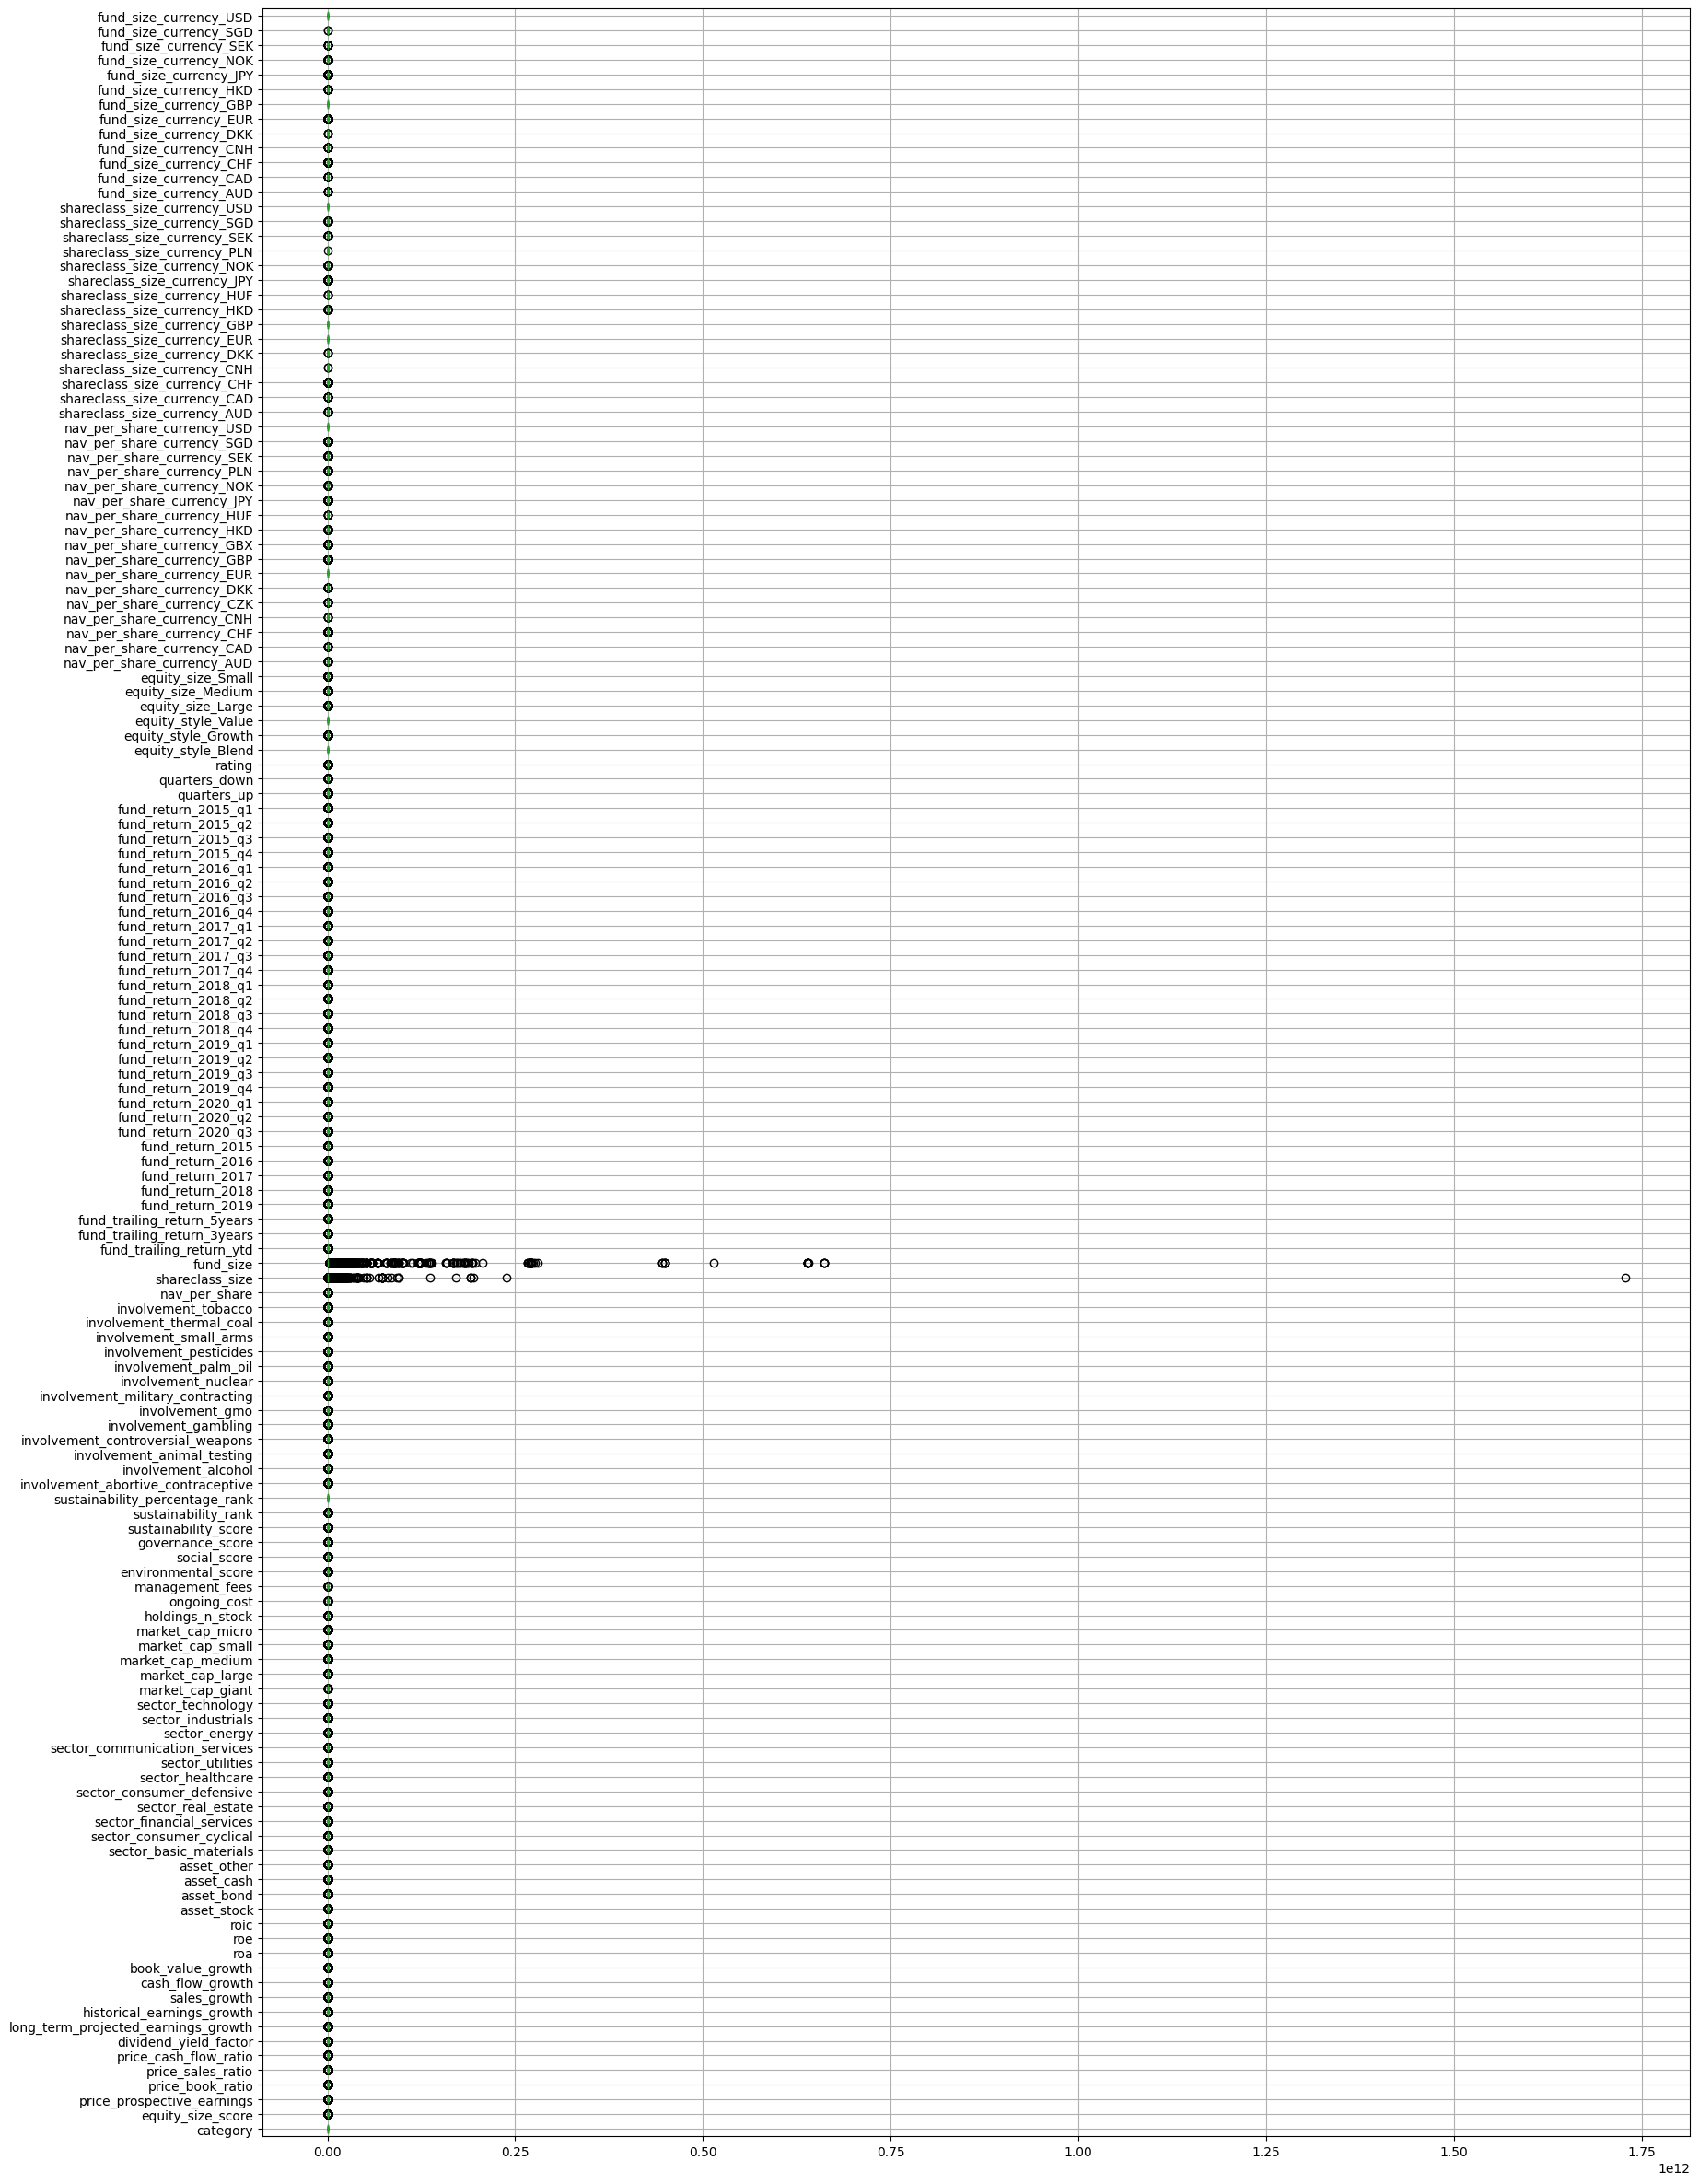

In [ ]:
ready_df_imputed.boxplot(vert=False, figsize=(20,30))
plt.show()

In [ ]:
ready_df_imputed = remove_outliers(ready_df_imputed, 'shareclass_size')

In [ ]:
ready_df_imputed = remove_outliers(ready_df_imputed, 'fund_size')

In [ ]:
ready_df_imputed.shape

(16764, 145)

In [ ]:
# List of all columns in the dataset
all_columns = ready_df_imputed.columns

# Columns that should be excluded from scaling:
# The original 'category' column and any columns that contain 'nav_per_share_currency', 'shareclass_size_currency', or 'fund_size_currency'
exclude_columns = ['category'] + [col for col in all_columns if any(currency_col in col for currency_col in ['nav_per_share_currency', 'shareclass_size_currency', 'fund_size_currency', 'equity_size', 'equity_style', 'long_term_projected_earnings_growth'])]

# Columns to be scaled: All columns except the ones to be excluded
features_to_scale = [col for col in all_columns if col not in exclude_columns]

# Displaying the columns that will be scaled and those that will be excluded
features_to_scale, exclude_columns

(['price_prospective_earnings',
  'price_book_ratio',
  'price_sales_ratio',
  'price_cash_flow_ratio',
  'dividend_yield_factor',
  'historical_earnings_growth',
  'sales_growth',
  'cash_flow_growth',
  'book_value_growth',
  'roa',
  'roe',
  'roic',
  'asset_stock',
  'asset_bond',
  'asset_cash',
  'asset_other',
  'sector_basic_materials',
  'sector_consumer_cyclical',
  'sector_financial_services',
  'sector_real_estate',
  'sector_consumer_defensive',
  'sector_healthcare',
  'sector_utilities',
  'sector_communication_services',
  'sector_energy',
  'sector_industrials',
  'sector_technology',
  'market_cap_giant',
  'market_cap_large',
  'market_cap_medium',
  'market_cap_small',
  'market_cap_micro',
  'holdings_n_stock',
  'ongoing_cost',
  'management_fees',
  'environmental_score',
  'social_score',
  'governance_score',
  'sustainability_score',
  'sustainability_rank',
  'sustainability_percentage_rank',
  'involvement_abortive_contraceptive',
  'involvement_alcohol',
 

In [ ]:
scaler = StandardScaler()

y = ready_df_imputed['long_term_projected_earnings_growth']
X = ready_df_imputed.drop(['long_term_projected_earnings_growth'], axis=1)

X[features_to_scale] = scaler.fit_transform(X[features_to_scale])
X_final = test_df_imputed.copy().drop(['long_term_projected_earnings_growth'], axis=1)
X_final[features_to_scale] = scaler.transform(X_final[features_to_scale])

In [ ]:
X.shape

(22420, 144)

In [ ]:
X_final.shape

(2803, 144)

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Modelling, Training, and Evaluating

Dalam tahap ini kami akan melakukan training model regresi dengan berbagai model regresi. Terdapat tiga model regresi yang kami coba yaitu:
1. XGB Regressor
2. LGBM Regressor
3. Cat Boost Regressor

### Eksperimen 1:XGB Regressor

In [ ]:
xgb_regressor = XGBRegressor(**xgb_params)

# Fit the XGBRegressor model on the training data
xgb_regressor.fit(X_train, y_train)

# Make predictions on the test data
xgb_reg_result = xgb_regressor.predict(X_test)

In [ ]:
xgb_regressor_submission = XGBRegressor(**xgb_params)

# Fit the XGBRegressor model on the training data
xgb_regressor_submission.fit(X, y)

# Make predictions on the test data
xgb_reg_result_submission = xgb_regressor_submission.predict(X_final)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, xgb_reg_result)
mse = mean_squared_error(y_test, xgb_reg_result)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, xgb_reg_result)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2) Score: {r2}")

Mean Absolute Error (MAE): 0.4000680652434101
Mean Squared Error (MSE): 0.6325443549853589
Root Mean Squared Error (RMSE): 0.7953265712808537
R-squared (R2) Score: 0.9550842420303356


In [ ]:
eim_test = pd.read_csv('EuropeanInvestmentManagement_test_regress.csv')

prediction_df = pd.DataFrame({
    "ticker": eim_test["ticker"],
    "long_term_projected_earnings_growth": xgb_reg_result_submission
})

prediction_df.to_csv('RegressionPrediction.csv', index=False)



### Eksperimen 2: LGBM Regressor

In [ ]:
lgbm_params = {
    'n_estimators': 2500,           # Number of boosting rounds (trees)
    'learning_rate': 0.1,         # Step size shrinkage used in update to prevent overfitting
    'max_depth': -1,              # Maximum depth of the individual trees (-1 means no limit)
    'min_child_samples': 20,      # Minimum number of data points to create a leaf
    'subsample': 1.0,            # Fraction of samples used for fitting the trees (1.0 means using all samples)
    'colsample_bytree': 1.0,      # Fraction of features used for fitting the trees (1.0 means using all features)
    'objective': 'regression',    # Objective function for regression tasks
    'metric': 'rmse',             # Evaluation metric for regression tasks
    'random_state': 42            # Random seed for reproducibility
}

In [ ]:
# Initialize the LGBMRegressor with your desired parameters
lgbm_regressor = LGBMRegressor(**lgbm_params)  # Replace lgbm_params with your desired hyperparameters

# Fit the LGBMRegressor model on the training data
lgbm_regressor.fit(X_train, y_train)

# Make predictions on the test data
lgbm_reg_result = lgbm_regressor.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22296
[LightGBM] [Info] Number of data points in the train set: 13644, number of used features: 98
[LightGBM] [Info] Start training from score 10.074219


In [ ]:
# Initialize the LGBMRegressor with your desired parameters
lgbm_regressor_submission = LGBMRegressor(**lgbm_params)  # Replace lgbm_params with your desired hyperparameters

# Fit the LGBMRegressor model on the training data
lgbm_regressor_submission.fit(X, y)

# Make predictions on the test data
lgbm_reg_result_submission = lgbm_regressor_submission.predict(X_final)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22324
[LightGBM] [Info] Number of data points in the train set: 17055, number of used features: 98
[LightGBM] [Info] Start training from score 10.092360


In [ ]:
mae = mean_absolute_error(y_test, lgbm_reg_result)
mse = mean_squared_error(y_test, lgbm_reg_result)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, lgbm_reg_result)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2) Score: {r2}")

Mean Absolute Error (MAE): 0.29592403645597126
Mean Squared Error (MSE): 0.6625640908045025
Root Mean Squared Error (RMSE): 0.8139803995210834
R-squared (R2) Score: 0.9607898142646827


In [ ]:
eim_test = pd.read_csv('EIM_test_reg.csv')

prediction_df = pd.DataFrame({
    "ticker": eim_test["ticker"],
    "long_term_projected_earnings_growth": lgbm_reg_result_submission
})

prediction_df.to_csv('RegressionLGBMPrediction.csv', index=False)

###  Eksperimen 3:Cat Boost Regressor

In [ ]:
catboost_params = {
    'iterations': 2000,            # Number of boosting iterations (trees)
    'learning_rate': 0.1,         # Step size shrinkage used in update to prevent overfitting
    'depth': 3,                   # Maximum depth of the individual trees
    'l2_leaf_reg': 3.0,           # L2 regularization term on weights
    'bagging_temperature': 1.0,   # Controls intensity of Bayesian bagging
    'random_seed': 42,            # Random seed for reproducibility
    'loss_function': 'RMSE'       # Loss function for regression tasks (Root Mean Squared Error)
}

In [ ]:
rcl_submission = CatBoostRegressor(**catboost_params)
rcl_submission.fit(X, y)
reg_result_submission = rcl_submission.predict(X_final)

0:	learn: 3.8288083	total: 61.5ms	remaining: 2m 2s
1:	learn: 3.7496867	total: 72.7ms	remaining: 1m 12s
2:	learn: 3.6767272	total: 82.8ms	remaining: 55.1s
3:	learn: 3.6163313	total: 93.2ms	remaining: 46.5s
4:	learn: 3.5542604	total: 105ms	remaining: 42s
5:	learn: 3.4933433	total: 115ms	remaining: 38.2s
6:	learn: 3.4357910	total: 125ms	remaining: 35.7s
7:	learn: 3.3953891	total: 135ms	remaining: 33.7s
8:	learn: 3.3525819	total: 146ms	remaining: 32.2s
9:	learn: 3.3162667	total: 156ms	remaining: 31s
10:	learn: 3.2775158	total: 174ms	remaining: 31.4s
11:	learn: 3.2473700	total: 186ms	remaining: 30.9s
12:	learn: 3.2127679	total: 197ms	remaining: 30.1s
13:	learn: 3.1825917	total: 209ms	remaining: 29.6s
14:	learn: 3.1567505	total: 220ms	remaining: 29.1s
15:	learn: 3.1311244	total: 230ms	remaining: 28.5s
16:	learn: 3.1074703	total: 240ms	remaining: 28s
17:	learn: 3.0831295	total: 250ms	remaining: 27.5s
18:	learn: 3.0650110	total: 265ms	remaining: 27.6s
19:	learn: 3.0437214	total: 275ms	remainin

In [ ]:
ccl = CatBoostRegressor(**catboost_params)
ccl.fit(X_train, y_train)
clas_result = ccl.predict(X_test)

0:	learn: 4.0060269	total: 9.25ms	remaining: 18.5s
1:	learn: 3.9236372	total: 17.2ms	remaining: 17.2s
2:	learn: 3.8494888	total: 25.6ms	remaining: 17.1s
3:	learn: 3.7884220	total: 34.1ms	remaining: 17s
4:	learn: 3.7246779	total: 42.3ms	remaining: 16.9s
5:	learn: 3.6733297	total: 50.4ms	remaining: 16.7s
6:	learn: 3.6201286	total: 58.5ms	remaining: 16.7s
7:	learn: 3.5666109	total: 66.9ms	remaining: 16.7s
8:	learn: 3.5199559	total: 75.2ms	remaining: 16.6s
9:	learn: 3.4784021	total: 83.8ms	remaining: 16.7s
10:	learn: 3.4426821	total: 98.8ms	remaining: 17.9s
11:	learn: 3.4105864	total: 113ms	remaining: 18.8s
12:	learn: 3.3796185	total: 122ms	remaining: 18.6s
13:	learn: 3.3454174	total: 130ms	remaining: 18.4s
14:	learn: 3.3164067	total: 139ms	remaining: 18.3s
15:	learn: 3.2894120	total: 147ms	remaining: 18.2s
16:	learn: 3.2629817	total: 155ms	remaining: 18.1s
17:	learn: 3.2360446	total: 165ms	remaining: 18.1s
18:	learn: 3.2135537	total: 173ms	remaining: 18.1s
19:	learn: 3.1873911	total: 184m

In [ ]:
mae = mean_absolute_error(y_test, clas_result)
mse = mean_squared_error(y_test, clas_result)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, clas_result)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2) Score: {r2}")

Mean Absolute Error (MAE): 0.6453698585310274
Mean Squared Error (MSE): 1.0295865287520256
Root Mean Squared Error (RMSE): 1.0146854333989552
R-squared (R2) Score: 0.9268910409684656


In [ ]:
eim_test = pd.read_csv('EIM_test_reg.csv')

prediction_df = pd.DataFrame({
    "ticker": eim_test["ticker"],
    "long_term_projected_earnings_growth": reg_result_submission
})

prediction_df.to_csv('RegressionCBPrediction.csv', index=False)



## Random Forest Regressor

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def regression_metrics(prediction, y_test):
    MAE = mean_absolute_error(y_test, prediction)
    MSE = mean_squared_error(y_test, prediction)
    RMSE = np.sqrt(MSE)
    R_squared = r2_score(y_test, prediction)

    print('MAE: ' + str(MAE))
    print('MSE: ' + str(MSE))
    print('RMSE: ' + str(RMSE))
    print('R_squared: ' + str(R_squared))

In [ ]:
low_correlation_columns = [col for col in low_correlation_columns if col != 'long_term_projected_earnings_growth']

reg_df_filtered = ready_df_imputed.drop(low_correlation_columns, axis=1)

reg_df_filtered.head()

category  equity_style  equity_size  equity_size_score  \
1      35.0           2.0          2.0             124.69   
2      98.0           3.0          3.0             322.70   
3     129.0           1.0          3.0             229.67   
4     132.0           3.0          2.0             111.36   
7     144.0           2.0          3.0             275.85   

   price_prospective_earnings  price_book_ratio  price_sales_ratio  \
1                       23.06              1.97               1.70   
2                       27.99              3.04               2.71   
3                       17.19              1.77               0.75   
4                       12.15              1.01               0.62   
7                       16.36              1.96               1.39   

   price_cash_flow_ratio  long_term_projected_earnings_growth  sales_growth  \
1                  12.07                                 9.34          7.55   
2                  10.35                                16.87         13.80   
3                   6.52                                 7.77          3.04   
4                   3.54                                10.02        -16.23   
7                  10.36                                 9.32          2.44   

   book_value_growth   roa    roe   roic  sector_technology  market_cap_giant  \
1               9.59  7.36  14.61  11.33              21.39              1.14   
2              14.76  7.83  16.35  11.62              23.42             62.38   
3               1.86  4.68  17.51   8.65              15.68             30.86   
4              -2.83  1.86   7.77   2.02              10.28             -0.08   
7               6.97  7.65  19.48  12.52              18.70             37.43   

   sustainability_rank  shareclass_size    fund_size  \
1                  2.0       17010000.0  771790000.0   
2                  4.0       30900000.0  128280000.0   
3                  2.0        6940000.0  297460000.0   
4                  2.0        1190000.0   18800000.0   
7                  3.6        1900000.0   99240000.0   

   fund_trailing_return_ytd  fund_trailing_return_3years  \
1                      1.65                         6.66   
2                     45.43                        13.19   
3                      3.61                         7.43   
4                     -1.86                         2.22   
7                      5.24                         3.95   

   fund_trailing_return_5years  fund_return_2019  fund_return_2018  \
1                       12.090             25.39             -5.72   
2                       18.480             22.29            -19.51   
3                       12.890             23.37             -6.10   
4                        8.582             20.20            -13.60   
7                        7.630              7.26              0.14   

   fund_return_2017  fund_return_2015  fund_return_2020_q3  \
1             1.740             7.120                 0.89   
2            29.120            -5.990                17.13   
3             6.130            -0.800                 4.01   
4            13.394            10.408                 1.36   
7             0.810             3.940                -2.69   

   fund_return_2020_q2  fund_return_2020_q1  fund_return_2019_q3  \
1                17.82               -24.09                 4.68   
2                27.23                -9.07                 1.42   
3                16.15               -22.56                 4.38   
4                27.48               -27.51                -1.85   
7                10.74                -3.82                 5.02   

   fund_return_2019_q2  fund_return_2019_q1  fund_return_2018_q1  \
1                 8.60                10.16                -5.35   
2                 3.90                 8.82                -9.37   
3                 5.28                11.49                -6.65   
4                11.95                 5.87                -6.92   
7           

In [ ]:
scaler = StandardScaler()

# Memisahkan antara fitur dan target
y_reg = reg_df_filtered['long_term_projected_earnings_growth']
X_reg = reg_df_filtered.drop(['long_term_projected_earnings_growth'],axis=1)

X_reg = scaler.fit_transform(X_reg)

In [ ]:
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, stratify=y, random_state=42)

### Experiment I: Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(max_depth=8, random_state=2023)
rf_reg.fit(X_reg_train, y_reg_train)

rf_prediction = rf_reg.predict(X_reg_test)

In [ ]:
regression_metrics(rf_prediction, y_reg_test)

MAE: 1.42187002450828
MSE: 4.317170166052275
RMSE: 2.077780105317277
R_squared: 0.7432526310740921


### Experiment II: Random Forest Regressor with Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'criterion': ['squared_error'],
    'min_samples_split': [10, 15, 20],
    'max_depth': [5, 10, 12, None]
}

rf_reg2 = RandomForestRegressor()
rnd_search = RandomizedSearchCV(estimator=rf_reg2, param_distributions=param_distributions,
                                n_iter=10, cv=5, random_state=42)
rnd_search.fit(X_reg_train, y_reg_train)

In [ ]:
rnd_search.best_params_

In [ ]:
rf_reg_tuned = RandomForestRegressor(min_samples_split=10, max_depth=None, criterion=squared_error)
rf_reg_tuned.fit(X_reg_train, y_reg_train)

rf_prediction_tuned = rf_reg_tuned.predict(X_reg_test)

In [ ]:
regression_metrics(rf_prediction_tuned, y_reg_test)

# Clustering

## K Means Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

num_of_cluster = [2, 3, 4, 5, 6, 7, 8]

fig, ax = plt.subplots(4, 2, figsize=(20,10))
for k in num_of_cluster:
    # Create KMeans instance for different number of clusters
    clusterer = KMeans(n_clusters = k, n_init=10)

    # Draw silhouette diagram
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(clusterer, colors = 'yellowbrick', ax = ax[q-1][mod])
    visualizer.fit(ready_df_imputed)

    # Compute silhoutte score
    # This gives a perspective into the density and separation of the formed clusters
    cluster_labels = clusterer.fit_predict(ready_df_imputed)
    silhouette_avg = silhouette_score(ready_df_imputed, cluster_labels)
    print(
        "For n_clusters =",
        k,
        "The average silhouette_coefficient is :",
        silhouette_avg,
    )

In [ ]:
kmeans = KMeans(n_clusters=2)

cluster_assignment = kmeans.fit_predict(X)
data_cluster = pd.DataFrame(ready_df_imputed.copy())
data_cluster['Clusters'] = cluster_assignment
data_cluster.head()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(style="whitegrid")

num_features = len(data_cluster.columns[:-2])
N = int(np.ceil(num_features / 2))

# Create the subplots
fig, axes = plt.subplots(N, 2, figsize=(10, 3*N))
fig.tight_layout(pad=4.0)

for i, feature in enumerate(data_cluster.columns[:-2]):
    row, col = divmod(i, 2)
    sns.boxplot(x='Clusters', y=feature, data=data_cluster, palette="Blues", ax=axes[row, col])
    axes[row, col].set_title(f'Boxplot of {feature} by Cluster')

if num_features % 2:
    axes[-1, -1].axis('off')

plt.show()

## Agglomerative Clustering

In [ ]:
import scipy.cluster.hierarchy as shc

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    shc.dendrogram(linkage_matrix, **kwargs)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(distance_threshold = 0, n_clusters = None, linkage = 'ward', affinity = 'euclidean')
clustering = model.fit(ready_df_imputed)
clustering.labels_

In [ ]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(14, 7))
plt.title("Dendrogram")
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node")
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

silhouette_scores = []

for n_clusters in range(2, 11):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    labels = model.fit_predict(ready_df_imputed)
    silhouette_avg = silhouette_score(ready_df_imputed, labels)
    silhouette_scores.append(silhouette_avg)

optimal_n_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  # +2 because range starts from 2

In [ ]:
print(f'the optimal clustering is {optimal_n_clusters} cluster with the silhouette score:{silhouette_scores[optimal_n_clusters-2]}')

In [ ]:
for i in range(len(silhouette_scores)):
  print(f'{i+2} cluster silhouette score: {silhouette_scores[i]} ')

In [ ]:
clustering = AgglomerativeClustering(n_clusters=2, linkage='ward', affinity='euclidean')

In [ ]:
cluster_assignment = clustering.fit_predict(ready_df_imputed)
data_cluster_agglo = pd.DataFrame(ready_df_imputed.copy())
data_cluster_agglo['Clusters'] = cluster_assignment
data_cluster_agglo.head()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(style="whitegrid")

num_features = len(data_cluster_agglo.columns[:-2])
N = int(np.ceil(num_features / 2))

# Create the subplots
fig, axes = plt.subplots(N, 2, figsize=(10, 3*N))
fig.tight_layout(pad=4.0)

for i, feature in enumerate(data_cluster_agglo.columns[:-2]):
    row, col = divmod(i, 2)
    sns.boxplot(x='Clusters', y=feature, data=data_cluster_agglo, palette="Blues", ax=axes[row, col])
    axes[row, col].set_title(f'Boxplot of {feature} by Cluster')

if num_features % 2:
    axes[-1, -1].axis('off')

plt.show()